In [1]:
%load_ext autoreload
%autoreload 2

In [361]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from scipy.stats import pearsonr
from scipy.special import factorial
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from fnn.evaluation import *
from fnn.utils import select_model
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
from fnn.notebook.utils import *
from torchdeepretina.datas import loadexpt
from torchdeepretina.pyret_func import estfr
import pyret

In [179]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_65.72_pearson_0.7311.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

BN_CNN_Stack(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.05, trainable=False, adapt=False, momentum=0.95)
    (4): ReLU()
  )
  (amacrine): Sequential(
    (0): Reshape(shape=(-1, 8, 36, 36))
    (1): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Seq

In [4]:
with h5py.File('/home/xhding/tem_stim/21-03-15/naturalscene.h5', 'r') as f:
    single_trial_bin = np.array(f['test']['repeats/binned'])
single_trial_bin = np.swapaxes(single_trial_bin,1,2)[:,40:6003,[0,1,2,3,4,6]]
scale_factor = single_trial_bin.mean(axis=1)/single_trial_bin.mean(axis=(0,1))
norm_single_trial_bin = single_trial_bin / np.expand_dims(scale_factor, 1)

In [183]:
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)
test_pc

0.8112149237536288

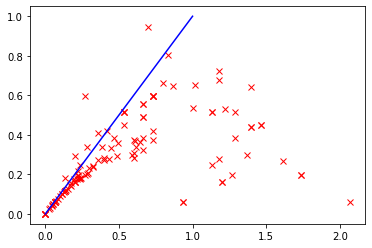

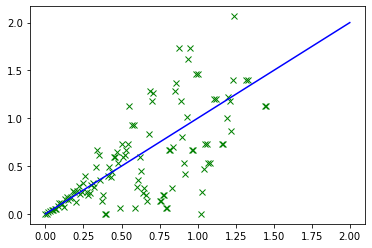

In [185]:
means = []
variances = []
rates = []
for rate in range(200):
    mean, var, _ = emperical(single_trial_bin, targ, cell=3, rate=rate)
    means.append(mean)
    variances.append(var)
    rates.append(rate/100)
plt.plot(means, variances, 'rx')
plt.plot([0, 1], [0, 1], 'b')
plt.show()
plt.plot(rates, means, 'gx')
plt.plot([0, 2], [0, 2], 'b')
plt.show()

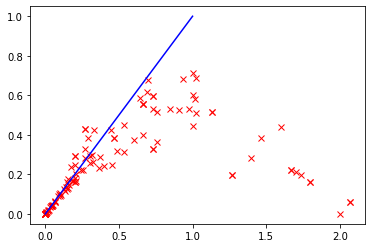

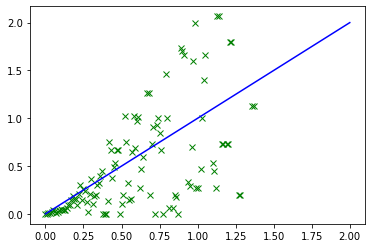

In [186]:
means = []
variances = []
rates = []
for rate in range(200):
    mean, var, _ = emperical(single_trial_bin, pred, cell=3, rate=rate)
    means.append(mean)
    variances.append(var)
    rates.append(rate/100)
plt.plot(means, variances, 'rx')
plt.plot([0, 1], [0, 1], 'b')
plt.show()
plt.plot(rates, means, 'gx')
plt.plot([0, 2], [0, 2], 'b')
plt.show()

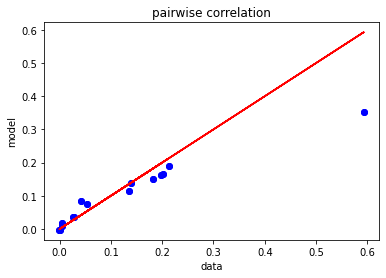

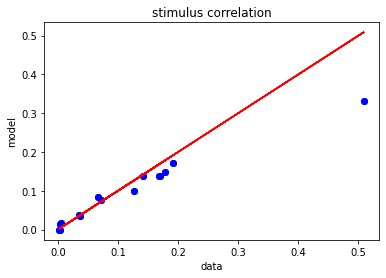

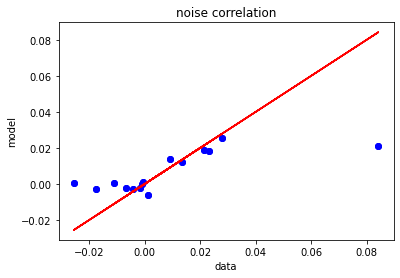

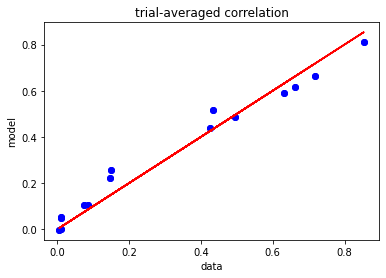

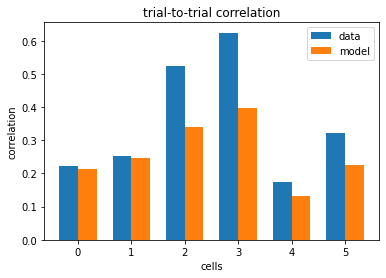

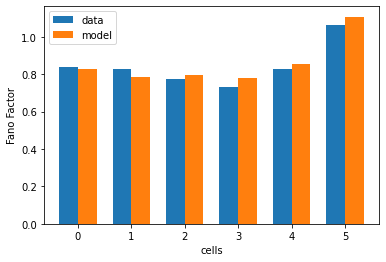

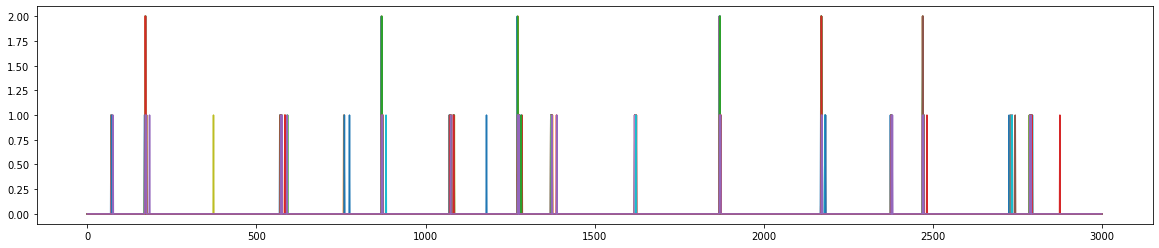

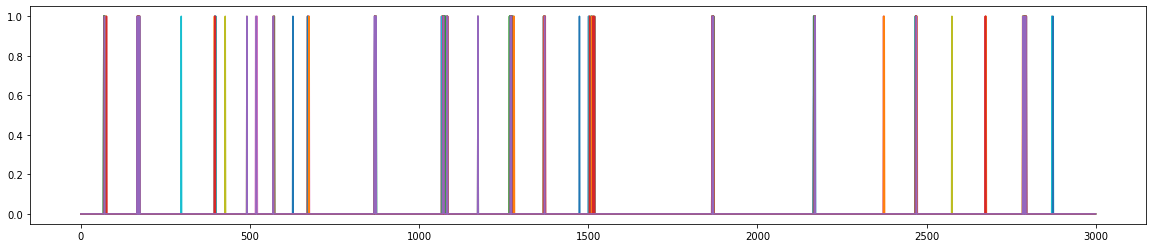

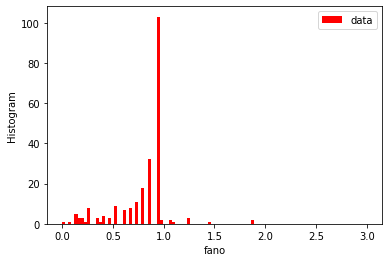

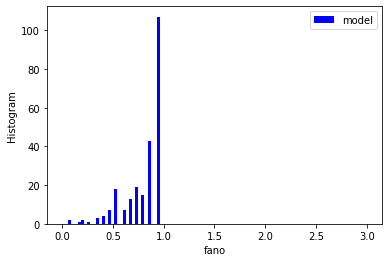

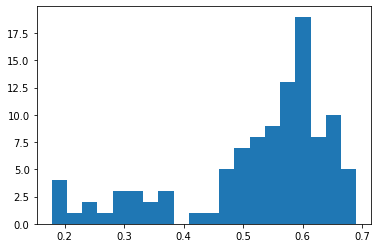

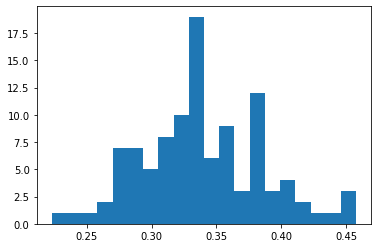

In [14]:
poisson_2s = [0.02, 0.02, 0.045, 0.25, 0.028, 0.0085]
torch.manual_seed(9)
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, n_repeats=15, n_cells=6, poisson=[None, None, poisson_2s], gaussian=[0., 0., 0.25, 0])
#pred_single_trial_pre[pred_single_trial_pre<8] = 0.
torch.manual_seed(28)
np.random.seed(28)
poisson_rates = (torch.rand(*pred_single_trial_pre.shape).to(device) * 0.1) - 0.05
poisson_rates += 0.01/torch.tensor(poisson_2s).to(device)
poisson_rates = 0.01/poisson_rates
pred_single_trial = torch.poisson(pred_single_trial_pre * poisson_rates) / poisson_rates
pred_single_trial = pred_single_trial.cpu().numpy()
pred_single_trial3 = pred_single_trial.copy()
pred_single_trial3[:, pred<3] = 0.
pred_single_trial3 = pred_single_trial3/100.
pred_single_trial3 = np.floor(np.random.rand(*pred_single_trial3.shape) + pred_single_trial3)
maxspikes = np.array([1,1,1,1,1,2])
for trial in range(15):
    extra = pred_single_trial3[trial] - maxspikes
    pred_single_trial3[trial] = np.minimum(pred_single_trial3[trial], maxspikes)
    extra[extra<0] = 0
    pred_single_trial3[(trial+1)%15] += extra
for trial in range(15):
    extra = pred_single_trial3[trial] - maxspikes
    pred_single_trial3[trial] = np.minimum(pred_single_trial3[trial], maxspikes)
    extra[extra<0] = 0
    pred_single_trial3[(trial+1)%15] += extra
maxspikes = np.array([2,2,2,2,2,3])
for trial in range(15):
    extra = pred_single_trial3[trial] - maxspikes
    pred_single_trial3[trial] = np.minimum(pred_single_trial3[trial], maxspikes)
    extra[extra<0] = 0
    pred_single_trial3[(trial+1)%15] += extra

correlation_plot(norm_single_trial_bin, pred_single_trial3, 15, 6)
cell = 2
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(single_trial_bin[:,1000:4000,cell], 0, 1))
plt.show()
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(pred_single_trial3[:,1000:4000,cell], 0, 1))
plt.show()
zero_idx = np.where(single_trial_bin[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(single_trial_bin[:,:,cell].var(0).flatten(), zero_idx)/np.delete(single_trial_bin[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='r', label='data')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial3[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(pred_single_trial3[:,:,cell].var(0).flatten(), zero_idx)/np.delete(pred_single_trial3[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='b', label='model')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(norm_single_trial_bin[i,:,cell], norm_single_trial_bin[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(pred_single_trial3[i,:,cell], pred_single_trial3[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()

In [110]:
single_trial_bin[:,:,5].max()

3.0

In [103]:
(single_trial_bin[:,:,4]>0).sum()

1300

In [104]:
(single_trial_bin[:,:,5]>0).sum()

1875

In [92]:
a = single_trial_bin - np.expand_dims(single_trial_bin.mean(1), axis=1)
b = a.std(1)
cell = 3
trial1 = 10
trial2 = 13
(a[trial1,:,cell]*a[trial2,:,cell]).mean()/b[trial1, cell]/b[trial2, cell]

0.7087926425787936

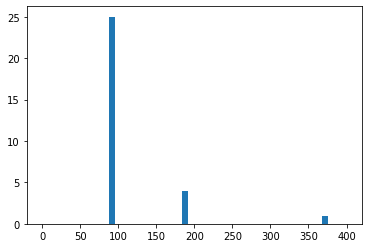

In [121]:
a = single_trial_bin - np.expand_dims(single_trial_bin.mean(1), axis=1)
b = a.std(1)
cell = 2
trial1 = 10
trial2 = 13
c = (a[trial1,:,cell]*a[trial2,:,cell])/b[trial1, cell]/b[trial2, cell]
plt.hist(c, bins=50, range=(0.02,400))
plt.show()

In [94]:
for i, value in enumerate(c):
    if value>50:
        print(value, single_trial_bin[trial1,i,cell], single_trial_bin[trial2,i,cell])

204.11132003598277 2.0 2.0
101.2622578951542 1.0 2.0
101.236178342587 2.0 1.0
50.22457352115331 1.0 1.0
50.22457352115331 1.0 1.0
50.22457352115331 1.0 1.0
50.22457352115331 1.0 1.0
50.22457352115331 1.0 1.0
50.22457352115331 1.0 1.0
101.236178342587 2.0 1.0
50.22457352115331 1.0 1.0
101.2622578951542 1.0 2.0
50.22457352115331 1.0 1.0
50.22457352115331 1.0 1.0
50.22457352115331 1.0 1.0
50.22457352115331 1.0 1.0
50.22457352115331 1.0 1.0
50.22457352115331 1.0 1.0
50.22457352115331 1.0 1.0
50.22457352115331 1.0 1.0
204.11132003598277 2.0 2.0
50.22457352115331 1.0 1.0
50.22457352115331 1.0 1.0
50.22457352115331 1.0 1.0
101.2622578951542 1.0 2.0
101.236178342587 2.0 1.0
50.22457352115331 1.0 1.0
204.11132003598277 2.0 2.0
50.22457352115331 1.0 1.0
50.22457352115331 1.0 1.0
101.236178342587 2.0 1.0
101.2622578951542 1.0 2.0
50.22457352115331 1.0 1.0
50.22457352115331 1.0 1.0
50.22457352115331 1.0 1.0
204.11132003598277 2.0 2.0
50.22457352115331 1.0 1.0
50.22457352115331 1.0 1.0
101.23617834

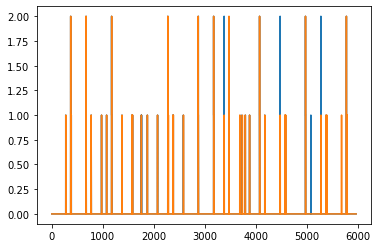

In [95]:
plt.plot(single_trial_bin[10, :, 3])
plt.plot(single_trial_bin[13, :, 3])
plt.show()

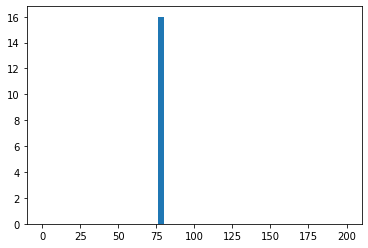

In [102]:
a = single_trial_bin - np.expand_dims(single_trial_bin.mean(1), axis=1)
b = a.std(1)
cell = 4
trial1 = 10
trial2 = 13
c = (a[trial1,:,cell]*a[trial2,:,cell])/b[trial1, cell]/b[trial2, cell]
plt.hist(c, bins=50, range=(0.02,200))
plt.show()

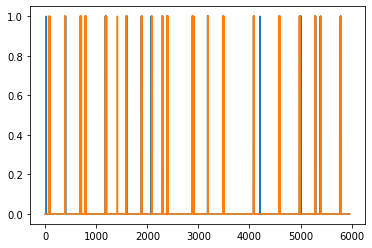

In [97]:
plt.plot(single_trial_bin[10, :, 4])
plt.plot(single_trial_bin[13, :, 4])
plt.show()

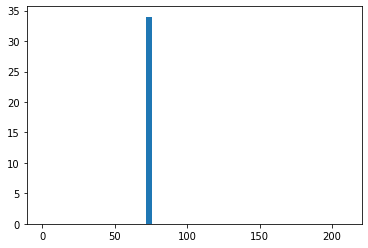

In [116]:
a = pred_single_trial3 - np.expand_dims(pred_single_trial3.mean(1), axis=1)
b = a.std(1)
cell = 3
trial1 = 10
trial2 = 13
c = (a[trial1,:,cell]*a[trial2,:,cell])/b[trial1, cell]/b[trial2, cell]
plt.hist(c, bins=50, range=(0.02,210))
plt.show()

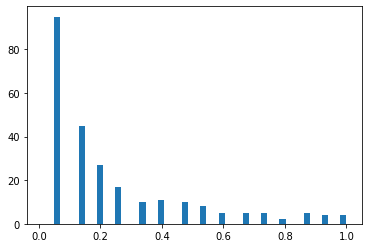

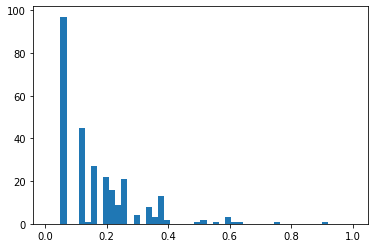

In [98]:
plt.hist(single_trial_bin[:,:,3].mean(0), range=(0.01, 1), bins=50)
plt.show()
plt.hist(single_trial_bin[:,:,3].var(0), range=(0.01, 1), bins=50)
plt.show()

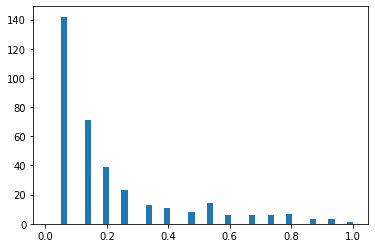

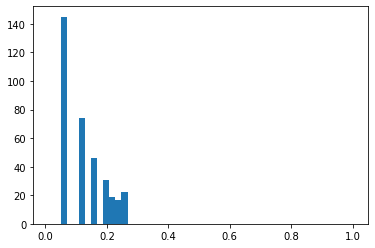

In [44]:
plt.hist(pred_single_trial3[:,:,3].mean(0), range=(0.01, 1), bins=50)
plt.show()
plt.hist(pred_single_trial3[:,:,3].var(0), range=(0.01, 1), bins=50)
plt.show()

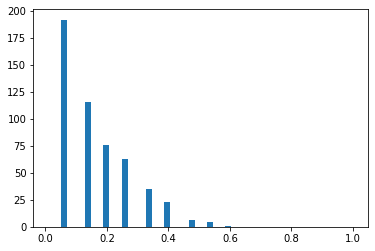

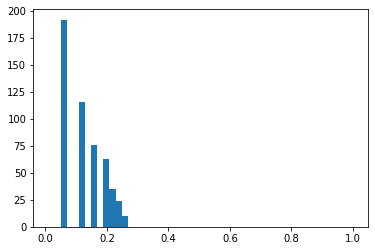

In [99]:
plt.hist(single_trial_bin[:,:,4].mean(0), range=(0.01, 1), bins=50)
plt.show()
plt.hist(single_trial_bin[:,:,4].var(0), range=(0.01, 1), bins=50)
plt.show()

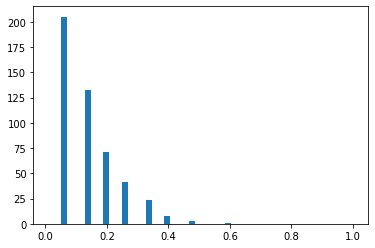

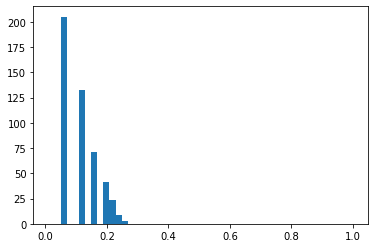

In [46]:
plt.hist(pred_single_trial3[:,:,4].mean(0), range=(0.01, 1), bins=50)
plt.show()
plt.hist(pred_single_trial3[:,:,4].var(0), range=(0.01, 1), bins=50)
plt.show()

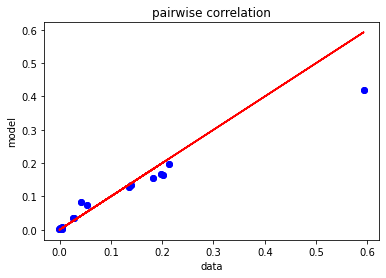

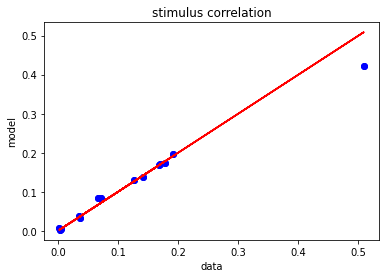

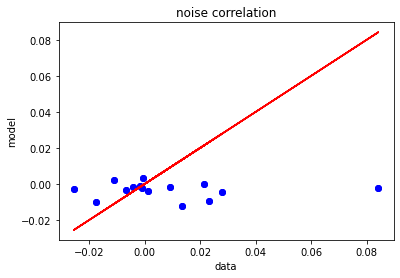

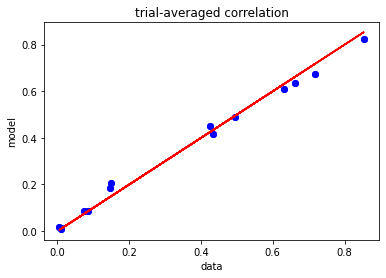

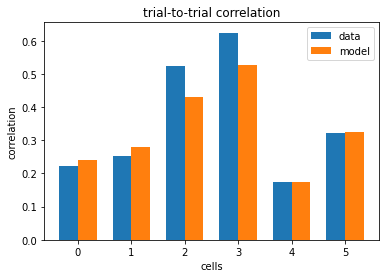

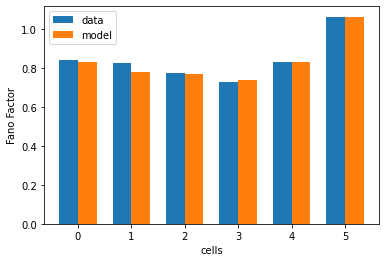

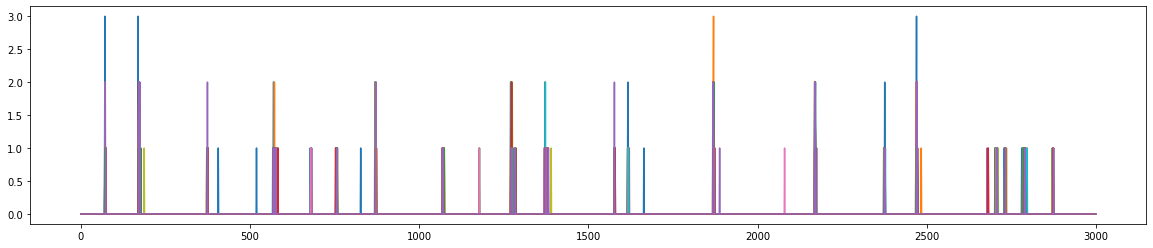

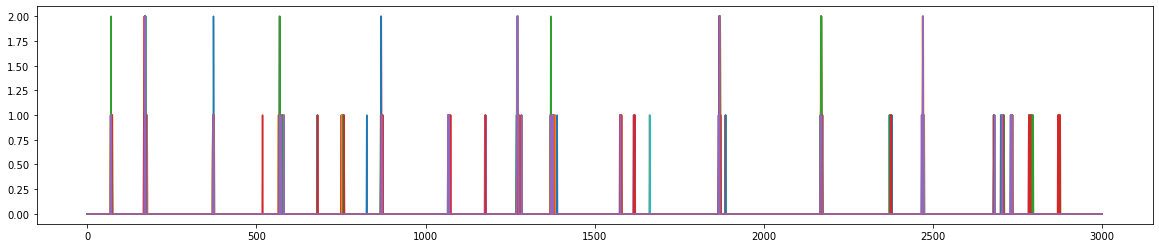

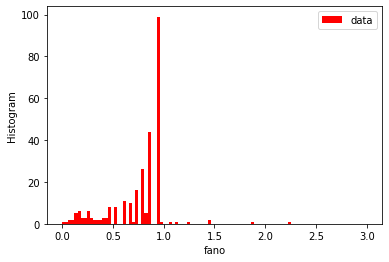

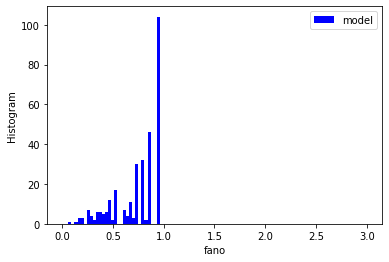

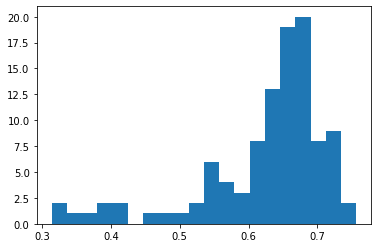

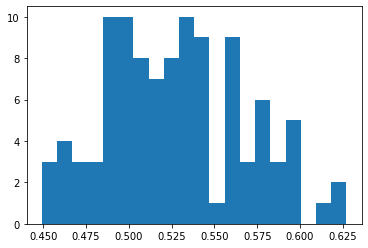

In [138]:
poisson_2s = [0.015, 0.012, 0.045, 0.04, 0.028, 0.0081]
#poisson_2s = [0.0117, 0.0126, 0.0127, 0.0133, 0.012, 0.0094]
torch.manual_seed(9)
pred_single_trial_pre = np.stack([targ for i in range(15)])
pred_single_trial_pre = torch.from_numpy(pred_single_trial_pre).to(device)
#pred_single_trial_pre[pred_single_trial_pre<8] = 0.
torch.manual_seed(28)
np.random.seed(28)
poisson_rates = (torch.rand(*pred_single_trial_pre.shape).to(device) * 0.1) - 0.05
poisson_rates += 0.01/torch.tensor(poisson_2s).to(device)
poisson_rates = 0.01/poisson_rates
pred_single_trial = torch.poisson(pred_single_trial_pre * poisson_rates) / poisson_rates
pred_single_trial = pred_single_trial.cpu().numpy()
pred_single_trial3 = pred_single_trial.copy()
#pred_single_trial3[:, pred<3] = 0.
pred_single_trial3 = pred_single_trial3/100.
pred_single_trial3 = np.floor(np.random.rand(*pred_single_trial3.shape) + pred_single_trial3)
maxspikes = np.array([1,1,2,2,1,2])
for trial in range(15):
    extra = pred_single_trial3[trial] - maxspikes
    pred_single_trial3[trial] = np.minimum(pred_single_trial3[trial], maxspikes)
    extra[extra<0] = 0
    pred_single_trial3[(trial+1)%15] += extra
for trial in range(15):
    extra = pred_single_trial3[trial] - maxspikes
    pred_single_trial3[trial] = np.minimum(pred_single_trial3[trial], maxspikes)
    extra[extra<0] = 0
    pred_single_trial3[(trial+1)%15] += extra
maxspikes = np.array([2,2,3,3,2,3])
for trial in range(15):
    extra = pred_single_trial3[trial] - maxspikes
    pred_single_trial3[trial] = np.minimum(pred_single_trial3[trial], maxspikes)
    extra[extra<0] = 0
    pred_single_trial3[(trial+1)%15] += extra

correlation_plot(norm_single_trial_bin, pred_single_trial3, 15, 6)
cell = 3
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(single_trial_bin[:,1000:4000,cell], 0, 1))
plt.show()
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(pred_single_trial3[:,1000:4000,cell], 0, 1))
plt.show()
zero_idx = np.where(single_trial_bin[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(single_trial_bin[:,:,cell].var(0).flatten(), zero_idx)/np.delete(single_trial_bin[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='r', label='data')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial3[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(pred_single_trial3[:,:,cell].var(0).flatten(), zero_idx)/np.delete(pred_single_trial3[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='b', label='model')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(norm_single_trial_bin[i,:,cell], norm_single_trial_bin[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(pred_single_trial3[i,:,cell], pred_single_trial3[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()

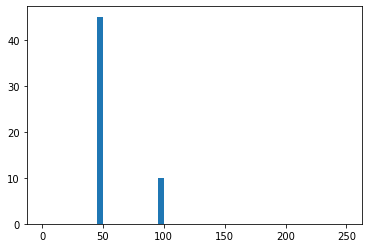

In [65]:
a = pred_single_trial3 - np.expand_dims(pred_single_trial3.mean(1), axis=1)
b = a.std(1)
cell = 3
trial1 = 10
trial2 = 13
c = (a[trial1,:,cell]*a[trial2,:,cell])/b[trial1, cell]/b[trial2, cell]
plt.hist(c, bins=50, range=(0.02,250))
plt.show()

In [81]:
(pred_single_trial3[:,:,3]==1).sum()

1381

In [82]:
(single_trial_bin[:,:,3]==1).sum()

1032

In [66]:
b[trial1, cell],b[trial2, cell]

(0.1424102897314804, 0.1377084158529965)

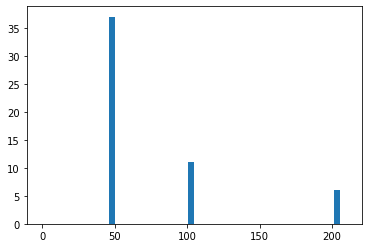

In [67]:
a = single_trial_bin - np.expand_dims(single_trial_bin.mean(1), axis=1)
b = a.std(1)
cell = 3
trial1 = 10
trial2 = 13
c = (a[trial1,:,cell]*a[trial2,:,cell])/b[trial1, cell]/b[trial2, cell]
plt.hist(c, bins=50, range=(0.02,210))
plt.show()

In [68]:
b[trial1, cell],b[trial2, cell]

(0.138619109295298, 0.1391660194273316)

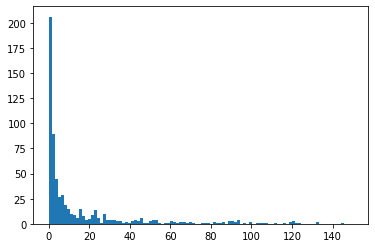

In [93]:
plt.hist(targ[:,3],bins=100, range=(0.01,150))
plt.show()

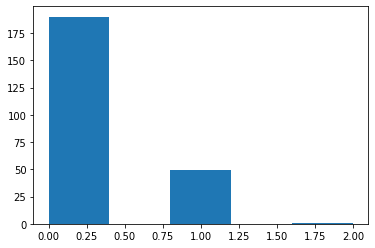

0.23 0.2125 0.17567708333333332 1.2096056922620813


In [114]:
cell = 3
rate = 23
p = single_trial_bin[:,((targ[:,cell]>=rate-1)*(targ[:,cell]<=rate+1)),3].flatten()
plt.hist(p, bins=4)
plt.show()
print(rate/100, p.mean(), p.var(), p.mean()/p.var())

In [275]:
np.array([]).mean()

nan

In [175]:
def emperical(single_trial_bin, targ, cell, rate):
    p = single_trial_bin[:,((targ[:,cell]>=rate-1)*(targ[:,cell]<=rate+1)),cell].flatten()
    return p.mean(), p.var(), p.mean()/p.var()

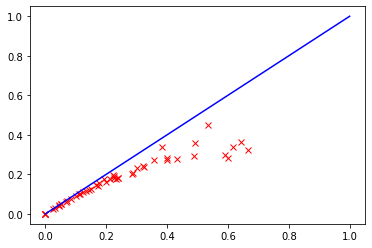

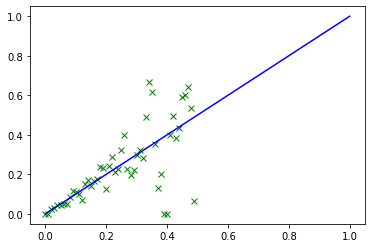

In [278]:
means = []
variances = []
rates = []
for rate in range(50):
    mean, var, _ = emperical(single_trial_bin, targ, cell=3, rate=rate)
    means.append(mean)
    variances.append(var)
    rates.append(rate/100)
plt.plot(means, variances, 'rx')
plt.plot([0, 1], [0, 1], 'b')
plt.show()
plt.plot(rates, means, 'gx')
plt.plot([0, 1], [0, 1], 'b')
plt.show()

In [127]:
1/np.nanmean(np.var(single_trial_bin, axis=0)/np.mean(single_trial_bin, axis=0), axis=0)

array([1.17036198, 1.26358653, 1.26566475, 1.32712929, 1.20186335,
       0.93669888])

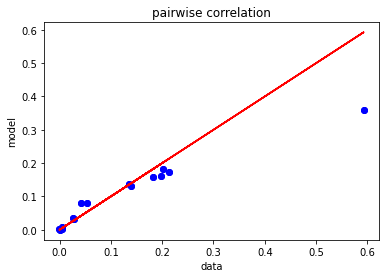

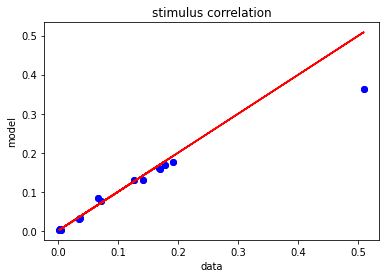

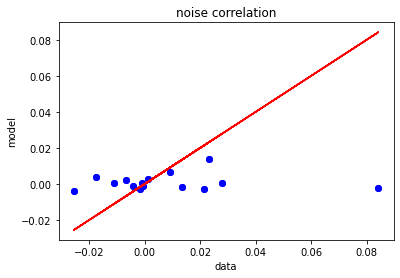

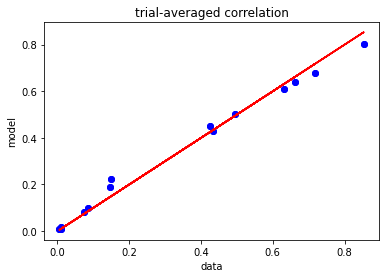

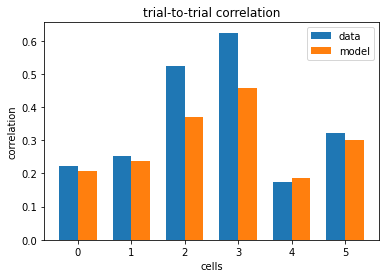

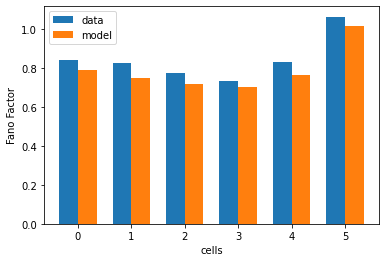

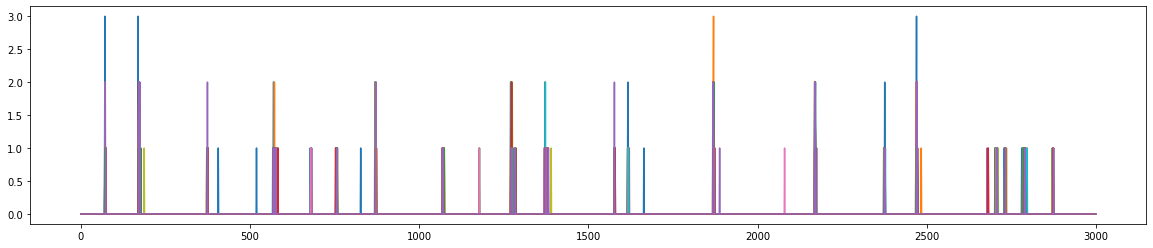

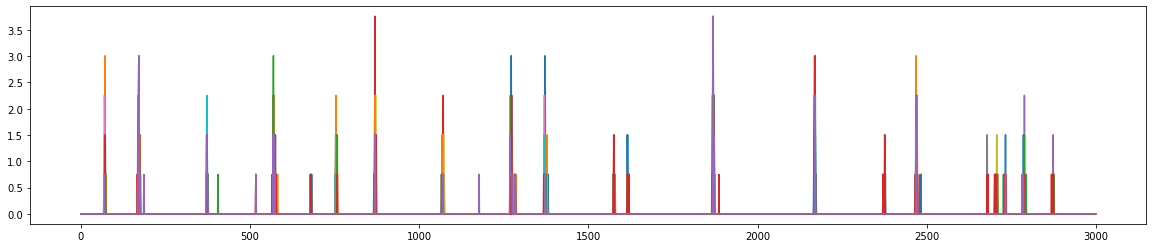

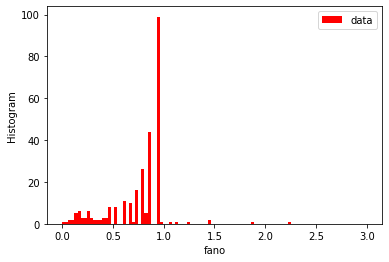

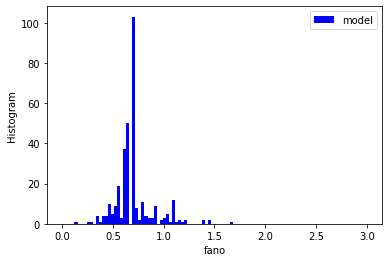

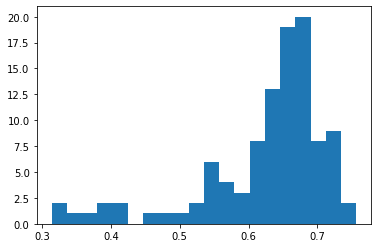

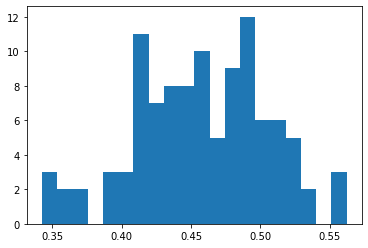

In [141]:
#poisson_2s = [0.02, 0.02, 0.045, 0.2, 0.028, 0.0085]
poisson_2s = [0.0117, 0.0126, 0.0127, 0.0133, 0.012, 0.0094]
torch.manual_seed(9)
pred_single_trial_pre = np.stack([targ for i in range(15)])
pred_single_trial_pre = torch.from_numpy(pred_single_trial_pre).to(device)
#pred_single_trial_pre[pred_single_trial_pre<8] = 0.
torch.manual_seed(28)
np.random.seed(28)
poisson_rates = torch.tensor(poisson_2s).to(device)
pred_single_trial = torch.poisson(pred_single_trial_pre * poisson_rates) / poisson_rates
pred_single_trial = pred_single_trial.cpu().numpy()
pred_single_trial3 = pred_single_trial.copy()
#pred_single_trial3[:, pred<3] = 0.
pred_single_trial3 = pred_single_trial3/100.
#pred_single_trial3 = np.floor(np.random.rand(*pred_single_trial3.shape) + pred_single_trial3)

correlation_plot(norm_single_trial_bin, pred_single_trial3, 15, 6)
cell = 3
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(single_trial_bin[:,1000:4000,cell], 0, 1))
plt.show()
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(pred_single_trial3[:,1000:4000,cell], 0, 1))
plt.show()
zero_idx = np.where(single_trial_bin[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(single_trial_bin[:,:,cell].var(0).flatten(), zero_idx)/np.delete(single_trial_bin[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='r', label='data')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial3[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(pred_single_trial3[:,:,cell].var(0).flatten(), zero_idx)/np.delete(pred_single_trial3[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='b', label='model')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(norm_single_trial_bin[i,:,cell], norm_single_trial_bin[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(pred_single_trial3[i,:,cell], pred_single_trial3[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()

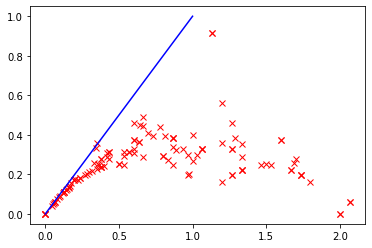

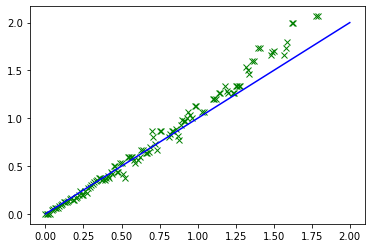

In [464]:
sigma = 0.0058
with h5py.File('/home/xhding/tem_stim/21-03-15/naturalscene.h5', 'r') as f:
    single_trial_bin = np.array(f['test']['repeats/binned'])
test_response = []
time_upsample = np.linspace(0, 60.02, 6003)
for trial in range(single_trial_bin.shape[0]):
    response = []
    for cell in range(single_trial_bin.shape[1]):
        rate = pyret.spiketools.estfr(single_trial_bin[trial, cell], time_upsample, sigma=sigma)
        response.append(rate)
    test_response.append(np.stack(response))
single_trial = np.stack(test_response)
single_trial_bin = np.swapaxes(single_trial_bin,1,2)[:,40:6003,[0,1,2,3,4,6]]
single_trial = np.swapaxes(single_trial,1,2)[:,40:6003,[0,1,2,3,4,6]]

means = []
variances = []
rates = []
for rate in range(200):
    mean, var, _ = emperical(single_trial_bin, single_trial.mean(0), cell=3, rate=rate)
    means.append(mean)
    variances.append(var)
    rates.append(rate/100)
plt.plot(means, variances, 'rx')
plt.plot([0, 1], [0, 1], 'b')
plt.show()
plt.plot(rates, means, 'gx')
plt.plot([0, 2], [0, 2], 'b')
plt.show()

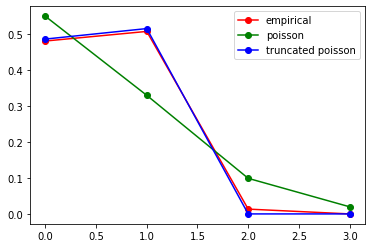

In [463]:
def poisson(rate, n):
    return np.exp(-rate)*rate**n/factorial(n)
def truncated_poisson(rate, n, t):
    summation = 0
    for i in range(t):
        summation += poisson(rate, i)
    if n >= t:
        return 0
    else:
        return poisson(rate, n)/summation

rate = 60
cell = 0
p = single_trial_bin[:,((targ[:,cell]>=rate-1)*(targ[:,cell]<=rate+1)),cell].flatten()
plt.plot(range(4), [(p == n).sum()/p.shape[0] for n in range(4)], 'r-o', label='empirical')
plt.plot(range(4), [poisson(rate/100, n) for n in range(4)], 'g-o', label='poisson')
plt.plot(range(4), [truncated_poisson(1.06, n, 2) for n in range(4)], 'b-o', label='truncated poisson')
plt.legend()
plt.show()

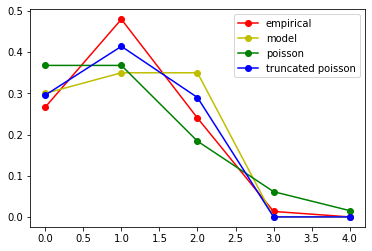

In [526]:
rate = 100
cell = 5
p = single_trial_bin[:,((100*single_trial_bin.mean(0)[:,cell]>=rate-1)*(100*single_trial_bin.mean(0)[:,cell]<=rate+1)),cell].flatten()
plt.plot(range(5), [(p == n).sum()/p.shape[0] for n in range(5)], 'r-o', label='empirical')
q = single_trial_bin[:,((100*pred_single_trial3.mean(0)[:,cell]>=rate-1)*(100*pred_single_trial3.mean(0)[:,cell]<=rate+1)),cell].flatten()
plt.plot(range(5), [(q == n).sum()/q.shape[0] for n in range(5)], 'y-o', label='model')
plt.plot(range(5), [poisson(rate/100, n) for n in range(5)], 'g-o', label='poisson')
plt.plot(range(5), [truncated_poisson(1.4, n, 3) for n in range(5)], 'b-o', label='truncated poisson')
plt.legend()
plt.show()

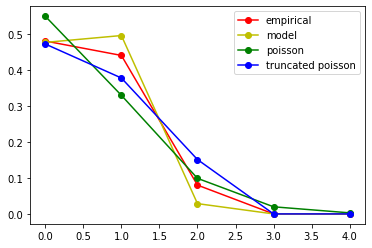

In [537]:
rate = 60
cell = 3
p = single_trial_bin[:,((100*single_trial_bin.mean(0)[:,cell]>=rate-1)*(100*single_trial_bin.mean(0)[:,cell]<=rate+1)),cell].flatten()
plt.plot(range(5), [(p == n).sum()/p.shape[0] for n in range(5)], 'r-o', label='empirical')
q = single_trial_bin[:,((100*pred_single_trial3.mean(0)[:,cell]>=rate-1)*(100*pred_single_trial3.mean(0)[:,cell]<=rate+1)),cell].flatten()
plt.plot(range(5), [(q == n).sum()/q.shape[0] for n in range(5)], 'y-o', label='model')
plt.plot(range(5), [poisson(rate/100, n) for n in range(5)], 'g-o', label='poisson')
plt.plot(range(5), [truncated_poisson(0.8, n, 3) for n in range(5)], 'b-o', label='truncated poisson')
plt.legend()
plt.show()

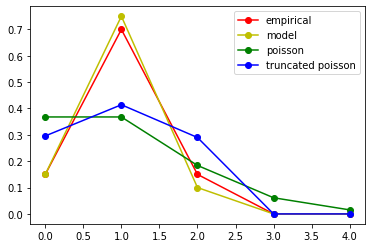

In [535]:
rate = 100
cell = 3
p = single_trial_bin[:,((100*single_trial_bin.mean(0)[:,cell]>=rate-1)*(100*single_trial_bin.mean(0)[:,cell]<=rate+1)),cell].flatten()
plt.plot(range(5), [(p == n).sum()/p.shape[0] for n in range(5)], 'r-o', label='empirical')
q = single_trial_bin[:,((100*pred_single_trial3.mean(0)[:,cell]>=rate-1)*(100*pred_single_trial3.mean(0)[:,cell]<=rate+1)),cell].flatten()
plt.plot(range(5), [(q == n).sum()/q.shape[0] for n in range(5)], 'y-o', label='model')
plt.plot(range(5), [poisson(rate/100, n) for n in range(5)], 'g-o', label='poisson')
plt.plot(range(5), [truncated_poisson(1.4, n, 3) for n in range(5)], 'b-o', label='truncated poisson')
plt.legend()
plt.show()

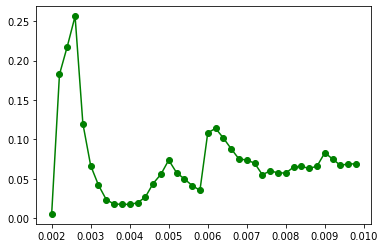

In [423]:
time_upsample = np.linspace(0, 60.02, 6003)
sigmas = np.arange(0.002, 0.010, 0.0002)
errors = []
for sigma in sigmas:
    with h5py.File('/home/xhding/tem_stim/21-03-15/naturalscene.h5', 'r') as f:
        single_trial_bin = np.array(f['test']['repeats/binned'])
    test_response = []
    for trial in range(single_trial_bin.shape[0]):
        response = []
        for cell in range(single_trial_bin.shape[1]):
            rate = pyret.spiketools.estfr(single_trial_bin[trial, cell], time_upsample, sigma=sigma)
            response.append(rate)
        test_response.append(np.stack(response))
    single_trial = np.stack(test_response)
    single_trial = np.swapaxes(single_trial,1,2)[:,40:6003,[0,1,2,3,4,6]]
    single_trial_bin = np.swapaxes(single_trial_bin,1,2)[:,40:6003,[0,1,2,3,4,6]]
    means = []
    variances = []
    rates = []
    for rate in range(300):
        mean, var, _ = emperical(single_trial_bin, single_trial.mean(0), cell=5, rate=rate)
        if not np.isnan(mean):
            means.append(mean)
            variances.append(var)
            rates.append(rate/100)
    error = np.abs(np.array(means) - np.array(rates)).mean()
    errors.append(error)
plt.plot(sigmas, errors, color='green', marker='o')

In [424]:
sigmas[15:][np.argsort(errors[15:])[0]]

0.005800000000000001

In [422]:
sigmas[20:][np.argsort(errors[20:])[0]]

0.008200000000000002

In [318]:
(single_trial_bin==3).sum((0,1))

array([ 0,  0,  0, 10,  0, 20])

In [342]:
(single_trial_bin==2).sum((0,1))

array([ 34,   6,  84, 227,   0, 598])

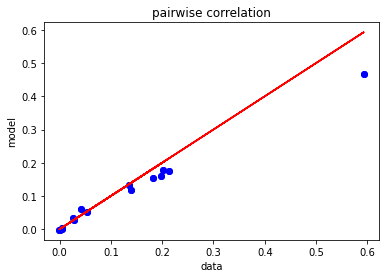

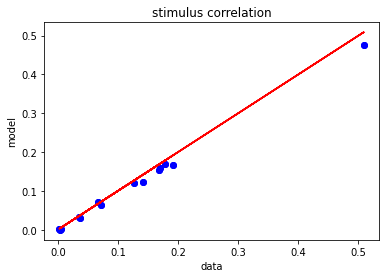

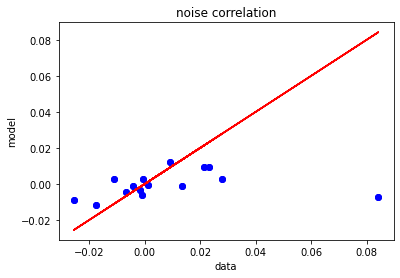

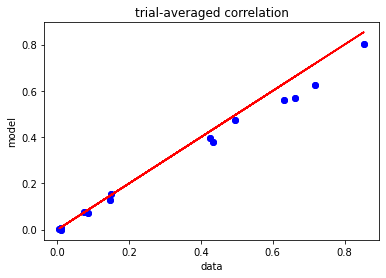

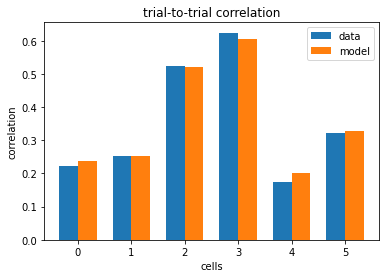

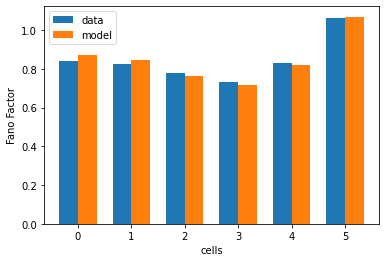

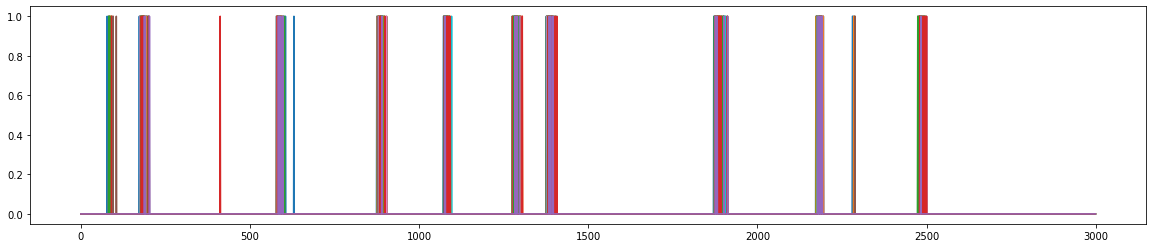

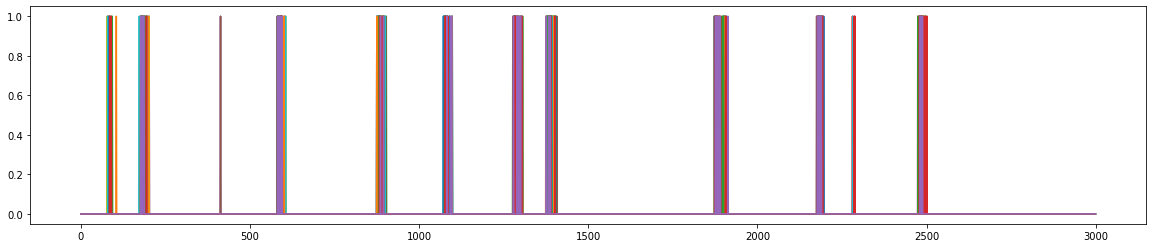

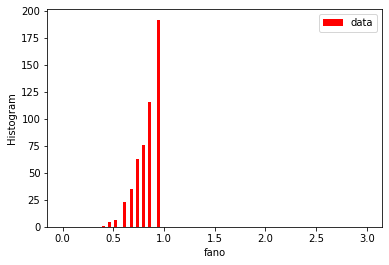

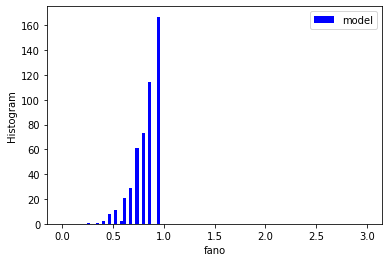

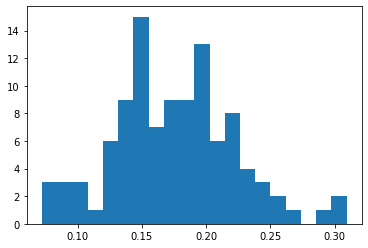

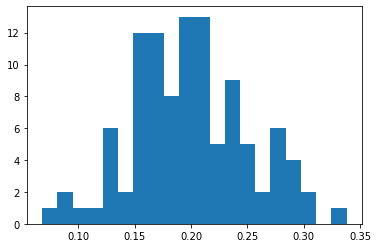

In [18]:
time_upsample = np.linspace(0, 60.02, 6003)
sigmas = [0.0038, 0.0038, 0.0038, 0.004, 0.009, 0.004, 0.004]
#sigmas = [0.0088, 0.0094, 0.0058, 0.0058, 0.009, 0.004, 0.0058]
#sigmas = [0.0088, 0.0094, 0.0078, 0.0082, 0.009, 0.004, 0.0082]
with h5py.File('/home/xhding/tem_stim/21-03-15/naturalscene.h5', 'r') as f:
    single_trial_bin = np.array(f['test']['repeats/binned'])
test_response = []
for trial in range(single_trial_bin.shape[0]):
    response = []
    for cell in range(single_trial_bin.shape[1]):
        rate = pyret.spiketools.estfr(single_trial_bin[trial, cell], time_upsample, sigma=sigmas[cell])
        response.append(rate)
    test_response.append(np.stack(response))
single_trial = np.stack(test_response)
single_trial = np.swapaxes(single_trial,1,2)[:,40:6003,[0,1,2,3,4,6]]
single_trial_bin = np.swapaxes(single_trial_bin,1,2)[:,40:6003,[0,1,2,3,4,6]]

poisson_2s = [0.018, 0.018, 0.03, 0.035, 0.01, 0.0092]

pred_single_trial_pre = np.stack([single_trial.mean(0) for i in range(15)])
pred_single_trial_pre = torch.from_numpy(pred_single_trial_pre).to(device)
#pred_single_trial_pre[pred_single_trial_pre<8] = 0.
torch.manual_seed(28)
np.random.seed(28)
poisson_rates = (torch.rand(*pred_single_trial_pre.shape).to(device) * 0.1) - 0.05
poisson_rates += 0.01/torch.tensor(poisson_2s).to(device)
poisson_rates = 0.01/poisson_rates
pred_single_trial = torch.poisson(pred_single_trial_pre * poisson_rates) / poisson_rates
pred_single_trial = pred_single_trial.cpu().numpy()
pred_single_trial3 = pred_single_trial.copy()
#pred_single_trial3[:, pred<3] = 0.
pred_single_trial3 = pred_single_trial3/100.
pred_single_trial3 = np.floor(np.random.rand(*pred_single_trial3.shape) + pred_single_trial3)
maxspikes = np.array([2,2,2,3,1,3])
for trial in range(15):
    extra = pred_single_trial3[trial] - maxspikes
    pred_single_trial3[trial] = np.minimum(pred_single_trial3[trial], maxspikes)
    extra[extra<0] = 0
    pred_single_trial3[(trial+1)%15] += extra
for trial in range(15):
    extra = pred_single_trial3[trial] - maxspikes
    pred_single_trial3[trial] = np.minimum(pred_single_trial3[trial], maxspikes)
    extra[extra<0] = 0
    pred_single_trial3[(trial+1)%15] += extra
for trial in range(15):
    extra = pred_single_trial3[trial] - maxspikes
    pred_single_trial3[trial] = np.minimum(pred_single_trial3[trial], maxspikes)
    extra[extra<0] = 0
    pred_single_trial3[(trial+1)%15] += extra

correlation_plot(norm_single_trial_bin, pred_single_trial3, 15, 6)
cell = 4
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(single_trial_bin[:,1000:4000,cell], 0, 1))
plt.show()
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(pred_single_trial3[:,1000:4000,cell], 0, 1))
plt.show()
zero_idx = np.where(single_trial_bin[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(single_trial_bin[:,:,cell].var(0).flatten(), zero_idx)/np.delete(single_trial_bin[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='r', label='data')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial3[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(pred_single_trial3[:,:,cell].var(0).flatten(), zero_idx)/np.delete(pred_single_trial3[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='b', label='model')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(norm_single_trial_bin[i,:,cell], norm_single_trial_bin[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(pred_single_trial3[i,:,cell], pred_single_trial3[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()

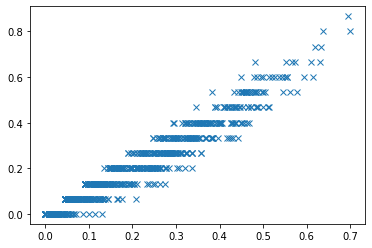

In [433]:
plt.plot(single_trial[:,:,1].mean(0)/100, single_trial_bin[:,:,1].mean(0), 'x')

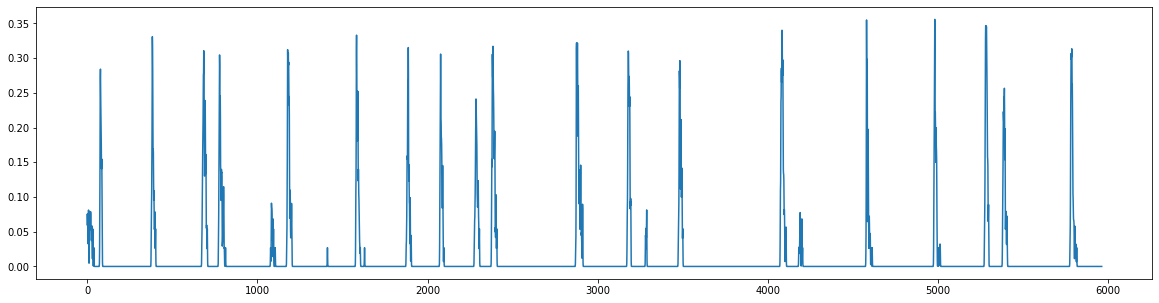

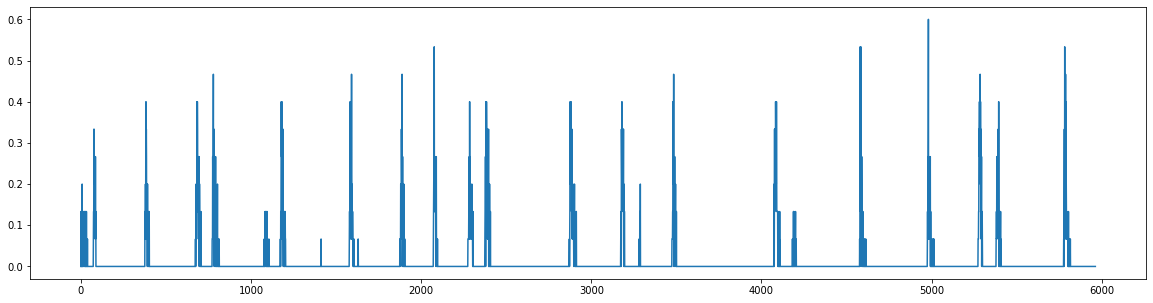

In [387]:
plt.figure(figsize=(20,5))
plt.plot(single_trial[:,:,4].mean(0)/100)
plt.show()
plt.figure(figsize=(20,5))
plt.plot(single_trial_bin[:,:,4].mean(0))
plt.show()

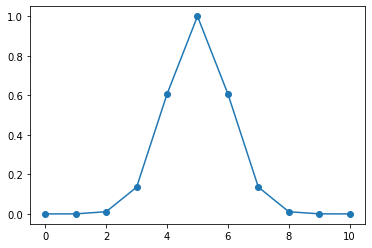

In [374]:
sigma = 0.010001
tau = np.arange(-5 * sigma, 5 * sigma, 0.01)
filt = np.exp(-0.5 * (tau / sigma) ** 2)
plt.plot(filt, '-o')

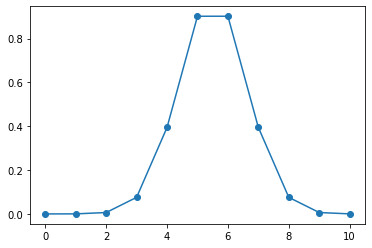

In [372]:
sigma = 0.011
tau = np.arange(-5 * sigma, 5 * sigma, 0.01)
filt = np.exp(-0.5 * (tau / sigma) ** 2)
plt.plot(filt, '-o')

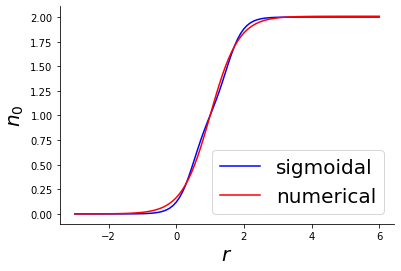

In [390]:
def truncated_gaussian(n, n0, s, t):
    summation = 0
    for i in range(t):
        summation += np.exp(-(i-n0)**2/2/s**2)
    if n >= t:
        return 0
    else:
        return np.exp(-(n-n0)**2/2/s**2)/summation

def mean_truncated_gaussian(n0, s, t):
    return np.sum([truncated_gaussian(i, n0, s, t)*i for i in range(t)])

s = 0.5
t = 3
n0_list = np.linspace(-3, 6, 100)
a,b,c = curve_fit(sigmoid_para, n0_list, [mean_truncated_gaussian(n0, s, t) for n0 in n0_list])[0]
plt.figure(figsize=(6,4))
plt.plot(n0_list, [mean_truncated_gaussian(n0, s, t) for n0 in n0_list], 'b', label='sigmoidal')
plt.plot(n0_list, [sigmoid_para(x,a,b,c) for x in n0_list], 'r', label='numerical')
plt.xlabel(r'$r$', fontsize=20)
plt.ylabel(r'$n_0$', fontsize=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(fontsize=20)

In [154]:
def sigmoid_para(x, a, b, c):
    return a/(1+1/np.exp((x-b)/c))

def inverse_sigmoid_para(x, a, b, c):
    if x == 0:
        return inverse_sigmoid_para(0.001, a, b, c)
    else:
        return b - c * np.log(a/x-1)

def log_likelihood_gaussian(s, single_trial_bin, cell, t):
    
    n0_list = np.linspace(-t, 2*t, 100)
    mean_list = [mean_truncated_gaussian(n0, s, t) for n0 in n0_list]
    a,b,c = curve_fit(sigmoid_para, n0_list, mean_list)[0]
    #f = interp1d(mean_list, n0_list)
    
    ll = 0
    for time in range(single_trial_bin.shape[1]):
        rate = single_trial_bin[:,time,cell].mean()
        n0 = inverse_sigmoid_para(rate, a, b, c)
        #n0 = max(f(rate), 0)
        for trial in range(single_trial_bin.shape[0]):
            n = single_trial_bin[trial,time,cell]
            ll += np.log(truncated_gaussian(n, n0, s, t))
    return ll

In [157]:
t = 3
cell = 0
a = 0.4
b = 2
assert np.sign(log_likelihood_gaussian(a, single_trial_bin, cell, t) - log_likelihood_gaussian(a+0.1, single_trial_bin, cell, t)) == -1
assert np.sign(log_likelihood_gaussian(b, single_trial_bin, cell, t) - log_likelihood_gaussian(b+0.1, single_trial_bin, cell, t)) == 1
while b-a > 0.01:
    c = (a+b)/2
    if b-a>0.5:
        d = 0.1
    else:
        d = 0.01
    sign = np.sign(log_likelihood_gaussian(c, single_trial_bin, cell, t) - log_likelihood_gaussian(c+d, single_trial_bin, cell, t))
    if sign == 1:
        b = c
    else:
        a = c
print(a)

0.6125


In [155]:
t = 3
cell = 1
a = 0.4
b = 2
assert np.sign(log_likelihood_gaussian(a, single_trial_bin, cell, t) - log_likelihood_gaussian(a+0.1, single_trial_bin, cell, t)) == -1
assert np.sign(log_likelihood_gaussian(b, single_trial_bin, cell, t) - log_likelihood_gaussian(b+0.1, single_trial_bin, cell, t)) == 1
while b-a > 0.01:
    c = (a+b)/2
    if b-a>0.5:
        d = 0.1
    else:
        d = 0.01
    sign = np.sign(log_likelihood_gaussian(c, single_trial_bin, cell, t) - log_likelihood_gaussian(c+d, single_trial_bin, cell, t))
    if sign == 1:
        b = c
    else:
        a = c
print(a)

0.5625


In [156]:
t = 3
cell = 2
a = 0.4
b = 2
assert np.sign(log_likelihood_gaussian(a, single_trial_bin, cell, t) - log_likelihood_gaussian(a+0.1, single_trial_bin, cell, t)) == -1
assert np.sign(log_likelihood_gaussian(b, single_trial_bin, cell, t) - log_likelihood_gaussian(b+0.1, single_trial_bin, cell, t)) == 1
while b-a > 0.01:
    c = (a+b)/2
    if b-a>0.5:
        d = 0.1
    else:
        d = 0.01
    sign = np.sign(log_likelihood_gaussian(c, single_trial_bin, cell, t) - log_likelihood_gaussian(c+d, single_trial_bin, cell, t))
    if sign == 1:
        b = c
    else:
        a = c
print(a)

0.5625


In [164]:
t = 4
cell = 3
a = 0.4
b = 2
assert np.sign(log_likelihood_gaussian(a, single_trial_bin, cell, t) - log_likelihood_gaussian(a+0.1, single_trial_bin, cell, t)) == -1
assert np.sign(log_likelihood_gaussian(b, single_trial_bin, cell, t) - log_likelihood_gaussian(b+0.1, single_trial_bin, cell, t)) == 1
while b-a > 0.01:
    c = (a+b)/2
    if b-a>0.5:
        d = 0.1
    else:
        d = 0.01
    sign = np.sign(log_likelihood_gaussian(c, single_trial_bin, cell, t) - log_likelihood_gaussian(c+d, single_trial_bin, cell, t))
    if sign == 1:
        b = c
    else:
        a = c
print(a)

0.6625000000000001


In [163]:
t = 2
cell = 4
for n0 in np.arange(0.4,2,0.1):
    print(n0, log_likelihood_gaussian(n0, single_trial_bin, cell, t))

0.4 -3268.969164601012
0.5 -3268.969164601012
0.6 -3268.969164601012
0.7 -3268.969164601012
0.7999999999999999 -3268.969164601012
0.8999999999999999 -3268.969164601012
0.9999999999999999 -3268.969164601012
1.0999999999999999 -3268.969164601012
1.1999999999999997 -3268.969164601012
1.2999999999999998 -3268.969164601012
1.4 -3268.9691646010124
1.4999999999999996 -3268.969164601012
1.5999999999999996 -3268.969164601012
1.6999999999999997 -3268.969164601012
1.7999999999999998 -3268.969164601012
1.8999999999999995 -3268.969164601012


In [160]:
t = 4
cell = 5
a = 0.4
b = 2
assert np.sign(log_likelihood_gaussian(a, single_trial_bin, cell, t) - log_likelihood_gaussian(a+0.1, single_trial_bin, cell, t)) == -1
assert np.sign(log_likelihood_gaussian(b, single_trial_bin, cell, t) - log_likelihood_gaussian(b+0.1, single_trial_bin, cell, t)) == 1
while b-a > 0.01:
    c = (a+b)/2
    if b-a>0.5:
        d = 0.1
    else:
        d = 0.01
    sign = np.sign(log_likelihood_gaussian(c, single_trial_bin, cell, t) - log_likelihood_gaussian(c+d, single_trial_bin, cell, t))
    if sign == 1:
        b = c
    else:
        a = c
print(a)

0.94375


In [165]:
n0_list = [0.61, 0.56, 0.56, 0.66, 1., 0.94]
t_list = [3,3,3,4,2,4]
tll = 0
for cell in range(6):
    ll = log_likelihood_gaussian(n0_list[cell], single_trial_bin, cell, t_list[cell])
    print(cell, ll)
    tll += ll
print('total ll', tll)

0 -7666.100865052863
1 -5878.159662076887
2 -1583.7649374080563
3 -2193.2507869307055
4 -3268.969164601012
5 -5044.454057082254
total ll -25634.699473151777


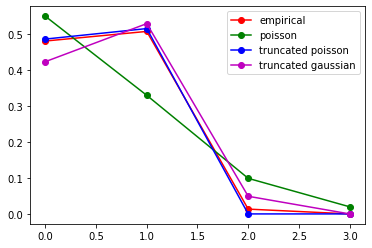

In [616]:
rate = 60
cell = 0
p = single_trial_bin[:,((targ[:,cell]>=rate-1)*(targ[:,cell]<=rate+1)),cell].flatten()
plt.plot(range(4), [(p == n).sum()/p.shape[0] for n in range(4)], 'r-o', label='empirical')
plt.plot(range(4), [poisson(rate/100, n) for n in range(4)], 'g-o', label='poisson')
plt.plot(range(4), [truncated_poisson(1.06, n, 2) for n in range(4)], 'b-o', label='truncated poisson')
t = 3
s = 0.62
n0_list = np.linspace(-t, 2*t, 100)
mean_list = [mean_truncated_gaussian(n0, s, t) for n0 in n0_list]
a,b,c = curve_fit(sigmoid_para, n0_list, mean_list)[0]
n0 = inverse_sigmoid_para(rate/100, a, b, c) 
plt.plot(range(4), [truncated_gaussian(n, n0, s, t) for n in range(4)], 'm-o', label='truncated gaussian')
plt.legend()
plt.show()

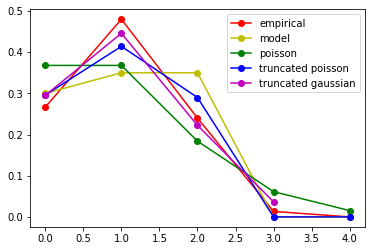

In [625]:
rate = 100
cell = 5
p = single_trial_bin[:,((100*single_trial_bin.mean(0)[:,cell]>=rate-1)*(100*single_trial_bin.mean(0)[:,cell]<=rate+1)),cell].flatten()
plt.plot(range(5), [(p == n).sum()/p.shape[0] for n in range(5)], 'r-o', label='empirical')
q = single_trial_bin[:,((100*pred_single_trial3.mean(0)[:,cell]>=rate-1)*(100*pred_single_trial3.mean(0)[:,cell]<=rate+1)),cell].flatten()
plt.plot(range(5), [(q == n).sum()/q.shape[0] for n in range(5)], 'y-o', label='model')
plt.plot(range(5), [poisson(rate/100, n) for n in range(5)], 'g-o', label='poisson')
plt.plot(range(5), [truncated_poisson(1.4, n, 3) for n in range(5)], 'b-o', label='truncated poisson')
t = 4
s = 0.95
n0_list = np.linspace(-t, 2*t, 100)
mean_list = [mean_truncated_gaussian(n0, s, t) for n0 in n0_list]
a,b,c = curve_fit(sigmoid_para, n0_list, mean_list)[0]
n0 = inverse_sigmoid_para(rate/100, a, b, c) 
plt.plot(range(4), [truncated_gaussian(n, n0, s, t) for n in range(4)], 'm-o', label='truncated gaussian')
plt.legend()
plt.show()

In [499]:
def poisson_scale3(n, r, k):
    p = 0
    for i in range(np.ceil(k*(n-0.5)).astype(np.int), np.ceil(k*(n+0.5)-1).astype(np.int)+1):
        if i >= 0:
            p += np.exp(-r*k)*(r*k)**i/factorial(i)
    return p

def truncated_poisson3(n, r, k, t):
    summation = 0
    for i in range(t):
        summation += poisson_scale3(i, r, k)
    if n >= t:
        return 0
    else:
        return poisson_scale3(n, r, k)/summation

def mean_truncated_poisson3(r, k, t):
    return np.sum([truncated_poisson3(i, r, k, t)*i for i in range(t)])

def log_likelihood_poisson3(k, single_trial_bin, cell, t):
    
    r_list = np.linspace(0, 2*t, 100)
    mean_list = [mean_truncated_poisson3(r, k, t) for r in r_list]
    f = interp1d(mean_list, r_list)
    
    ll = 0
    for time in range(single_trial_bin.shape[1]):
        rate = single_trial_bin[:,time,cell].mean()
        r = max(f(rate), 0)
        for trial in range(single_trial_bin.shape[0]):
            n = single_trial_bin[trial,time,cell]
            ll += np.log(truncated_poisson3(n, r, k, t))
    return ll

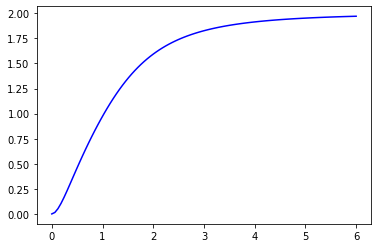

In [497]:
k = 3
t = 3
r_list = np.linspace(0, 6, 100)
mean_list = [mean_truncated_poisson3(r, k, t) for r in r_list]  
plt.plot(r_list, mean_list, 'b')

In [503]:
t = 3
cell = 0
for k in np.arange(1., 5.0, 0.2):
    print(k, log_likelihood_poisson3(k, single_trial_bin, cell, t))

1.0 -7939.57745790308
1.2 -7939.5774127716295
1.4 -7588.798832897476
1.5999999999999999 -7588.855264264853
1.7999999999999998 -7598.886743684059
1.9999999999999998 -7598.983020694232
2.1999999999999997 -7748.413732856149
2.3999999999999995 -7748.436569977236
2.5999999999999996 -7758.930773220212
2.8 -7586.1256685667295
2.9999999999999996 -7589.169547341149
3.1999999999999993 -7589.086661513217
3.3999999999999995 -7568.637610507465
3.5999999999999996 -7568.727738477271
3.7999999999999994 -7569.16308736129
3.999999999999999 -7569.521760887829
4.199999999999999 -7574.393658864207
4.3999999999999995 -7574.45402664229
4.6 -7574.658845706482
4.799999999999999 -7569.011138170489


In [5]:
def poisson_scale(n, r, k):
    p = 0
    for i in range(np.ceil(k*(n-1)).astype(np.int), np.floor(k*(n+1)).astype(np.int)+1):
        if i >= 0:
            p += np.exp(-r*k)*(r*k)**i/factorial(i)*(1-np.abs(i/k-n))
    return p

def truncated_poisson(n, r, k, t):
    summation = 0
    for i in range(t):
        summation += poisson_scale(i, r, k)
    if n >= t:
        return 0
    else:
        return poisson_scale(n, r, k)/summation

def mean_truncated_poisson(r, k, t):
    return np.sum([truncated_poisson(i, r, k, t)*i for i in range(t)])

2.0126720590012073 0.24489640033391133 0.632664240041769 0.04344977639567269
1.018502118173279


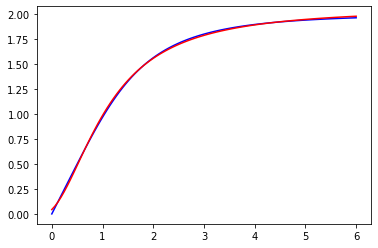

In [127]:
def sat_func(x,a,b,c,d):
    return a*(b*x+c*x**2)/(1+b*x+c*x**2)+d

def inverse_sat(x,a,b,c,d):
    m = -1/(a/(x-d)-1)
    solution = (-b+np.sqrt(b**2-4*c*m))/2/c
    return max(0, solution)

def log_likelihood_poisson(k, single_trial_bin, cell, t):
    
    r_list = np.linspace(0, 2*t, 100)
    mean_list = [mean_truncated_poisson(r, k, t) for r in r_list]
    #a,b,c,d = curve_fit(sat_func, r_list, mean_list)[0]
    f = interp1d(mean_list, r_list)
    
    ll = 0
    for time in range(single_trial_bin.shape[1]):
        rate = single_trial_bin[:,time,cell].mean()
        #r = inverse_sat(rate, a, b, c, d)
        r = max(f(rate), 0)
        for trial in range(single_trial_bin.shape[0]):
            n = single_trial_bin[trial,time,cell]
            ll += np.log(truncated_poisson(n, r, k, t))
    return ll
    
k = 3
t = 3
r_list = np.linspace(0, 6, 100)
mean_list = [mean_truncated_poisson(r, k, t) for r in r_list]  
a,b,c,d = curve_fit(sat_func, r_list, mean_list)[0]
plt.plot(r_list, mean_list, 'b')
plt.plot(r_list, [sat_func(r,a,b,c,d) for r in r_list], 'r')
print(a,b,c,d)
print(inverse_sat(1.,a,b,c,d))

In [129]:
t = 3
cell = 0
a = 1
b = 10
assert np.sign(log_likelihood_poisson(a, single_trial_bin, cell, t) - log_likelihood_poisson(a+0.1, single_trial_bin, cell, t)) == -1
assert np.sign(log_likelihood_poisson(b, single_trial_bin, cell, t) - log_likelihood_poisson(b+0.1, single_trial_bin, cell, t)) == 1
while b-a > 0.01:
    c = (a+b)/2
    if b-a>0.5:
        d = 0.1
    else:
        d = 0.01
    sign = np.sign(log_likelihood_poisson(c, single_trial_bin, cell, t) - log_likelihood_poisson(c+d, single_trial_bin, cell, t))
    if sign == 1:
        b = c
    else:
        a = c
print(a)

5.5615234375


In [130]:
t = 3
cell = 1
a = 1
b = 10
assert np.sign(log_likelihood_poisson(a, single_trial_bin, cell, t) - log_likelihood_poisson(a+0.1, single_trial_bin, cell, t)) == -1
assert np.sign(log_likelihood_poisson(b, single_trial_bin, cell, t) - log_likelihood_poisson(b+0.1, single_trial_bin, cell, t)) == 1
while b-a > 0.01:
    c = (a+b)/2
    if b-a>0.5:
        d = 0.1
    else:
        d = 0.01
    sign = np.sign(log_likelihood_poisson(c, single_trial_bin, cell, t) - log_likelihood_poisson(c+d, single_trial_bin, cell, t))
    if sign == 1:
        b = c
    else:
        a = c
print(a)

8.8662109375


In [131]:
t = 3
cell = 2
a = 1
b = 10
assert np.sign(log_likelihood_poisson(a, single_trial_bin, cell, t) - log_likelihood_poisson(a+0.1, single_trial_bin, cell, t)) == -1
assert np.sign(log_likelihood_poisson(b, single_trial_bin, cell, t) - log_likelihood_poisson(b+0.1, single_trial_bin, cell, t)) == 1
while b-a > 0.01:
    c = (a+b)/2
    if b-a>0.5:
        d = 0.1
    else:
        d = 0.01
    sign = np.sign(log_likelihood_poisson(c, single_trial_bin, cell, t) - log_likelihood_poisson(c+d, single_trial_bin, cell, t))
    if sign == 1:
        b = c
    else:
        a = c
print(a)

4.6474609375


In [141]:
t = 4
cell = 3
a = 1
b = 10
assert np.sign(log_likelihood_poisson(a, single_trial_bin, cell, t) - log_likelihood_poisson(a+0.1, single_trial_bin, cell, t)) == -1
assert np.sign(log_likelihood_poisson(b, single_trial_bin, cell, t) - log_likelihood_poisson(b+0.1, single_trial_bin, cell, t)) == 1
while b-a > 0.01:
    c = (a+b)/2
    if b-a>0.5:
        d = 0.1
    else:
        d = 0.01
    sign = np.sign(log_likelihood_poisson(c, single_trial_bin, cell, t) - log_likelihood_poisson(c+d, single_trial_bin, cell, t))
    if sign == 1:
        b = c
    else:
        a = c
print(a)

4.7529296875


In [135]:
t = 2
cell = 4
for k in np.arange(1., 5.0, 1.):
    print(k, log_likelihood_poisson(k, single_trial_bin, cell, t))

1.0 -3187.2248608609993
2.0 -3187.223657248563
3.0 -3187.2233868658063
4.0 -3187.2233404338112


In [139]:
t = 4
cell = 5
a = 0.6
b = 2
assert np.sign(log_likelihood_poisson(a, single_trial_bin, cell, t) - log_likelihood_poisson(a+0.1, single_trial_bin, cell, t)) == -1
assert np.sign(log_likelihood_poisson(b, single_trial_bin, cell, t) - log_likelihood_poisson(b+0.1, single_trial_bin, cell, t)) == 1
while b-a > 0.01:
    c = (a+b)/2
    if b-a>0.5:
        d = 0.1
    else:
        d = 0.01
    sign = np.sign(log_likelihood_poisson(c, single_trial_bin, cell, t) - log_likelihood_poisson(c+d, single_trial_bin, cell, t))
    if sign == 1:
        b = c
    else:
        a = c
print(a)

1.4859375000000001


In [150]:
k_list = [5.56, 8.87, 4.65, 4.75, 1., 1.49]
t_list = [3,3,3,4,2,4]
tll = 0
for cell in range(6):
    ll = log_likelihood_poisson(k_list[cell], single_trial_bin, cell, t_list[cell])
    print(cell, ll)
    tll += ll
print('total ll', tll)

0 -7580.3899686916975
1 -5779.258678852624
2 -1578.9863262646181
3 -2171.8021052685294
4 -3187.2248608609993
5 -4921.655879088941
total ll -25219.317819027412


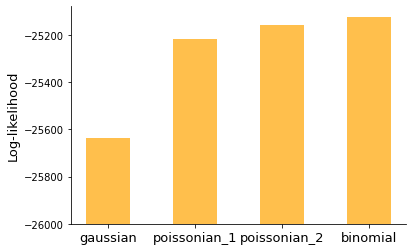

In [483]:
fig, ax = plt.subplots()
bottom = 26000
labels = ['gaussian', 'poissonian_1', 'poissonian_2', 'binomial']
x = np.arange(len(labels))
y = np.array([-25635, -25219, -25159, -25124]) + bottom
rect = ax.bar(x, y, color='orange', alpha=0.7, width=0.5, bottom = -bottom)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=13)
ax.set_ylabel('Log-likelihood', fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

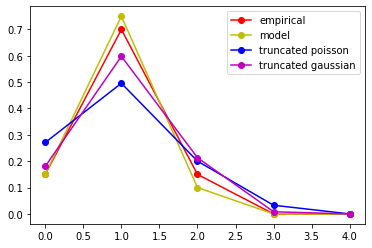

In [22]:
rate = 100
cell = 3
t = 4
p = single_trial_bin[:,((100*single_trial_bin.mean(0)[:,cell]>=rate-1)*(100*single_trial_bin.mean(0)[:,cell]<=rate+1)),cell].flatten()
plt.plot(range(5), [(p == n).sum()/p.shape[0] for n in range(5)], 'r-o', label='empirical')
q = single_trial_bin[:,((100*pred_single_trial3.mean(0)[:,cell]>=rate-1)*(100*pred_single_trial3.mean(0)[:,cell]<=rate+1)),cell].flatten()
plt.plot(range(5), [(q == n).sum()/q.shape[0] for n in range(5)], 'y-o', label='model')
k = 1.99
r_list = np.linspace(0, 2*t, 100)
mean_list = [mean_truncated_poisson(r, k, t) for r in r_list]  
a,b,c,d = curve_fit(sat_func, r_list, mean_list)[0]
r = inverse_sat(rate/100, a, b, c, d)
plt.plot(range(5), [truncated_poisson(n, r, k, t) for n in range(5)], 'b-o', label='truncated poisson')
s = 0.67
n0_list = np.linspace(-t, 2*t, 100)
mean_list = [mean_truncated_gaussian(n0, s, t) for n0 in n0_list]
a,b,c = curve_fit(sigmoid_para, n0_list, mean_list)[0]
n0 = inverse_sigmoid_para(rate/100, a, b, c) 
plt.plot(range(5), [truncated_gaussian(n, n0, s, t) for n in range(5)], 'm-o', label='truncated gaussian')
plt.legend()
plt.show()

In [52]:
'''
def binomial_scale(n, p, M, k):
    pr = 0
    for i in range(np.floor(k*(n-1)).astype(np.int)+1, np.ceil(k*(n+1)).astype(np.int)):
        if i >= 0:
            pr += factorial(k*M)/factorial(i)/factorial(k*M-i)*p**i*(1-p)**(k*M-i)*(1-np.abs(i/k-n))
            if np.isinf(pr):
                print(factorial(k*M),factorial(i),factorial(k*M-i),p**i*(1-p)**(k*M-i),(1-np.abs(i/k-n)))
                raise
    return pr
'''
def binomial_scale(n, p, M, k):
    summation = np.sum([factorial(k*M)/factorial(k*i)/factorial(k*M-k*i)*p**(k*i)*(1-p)**(k*M-k*i) for i in range(M+1)])
    pr = factorial(k*M)/factorial(k*n)/factorial(k*M-k*n)*p**(k*n)*(1-p)**(k*M-k*n) / summation
    return pr

def mean_binomial(p, k, t):
    return np.sum([binomial_scale(i, p, t-1, k)*i for i in range(t)])

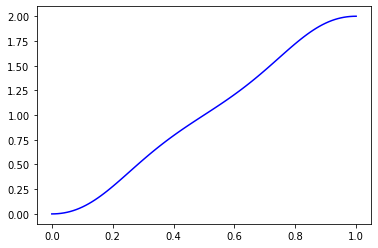

In [58]:
k = 2
t = 3
p_list = np.linspace(0, 1, 100)
mean_list = [mean_binomial(p, k, t) for p in p_list]  
plt.plot(p_list, mean_list, 'b')

In [61]:
def log_likelihood_binomial(k, single_trial_bin, cell, t):
    
    p_list = np.linspace(0, 1, 100)
    mean_list = [mean_binomial(p, k, t) for p in p_list]
    f = interp1d(mean_list, p_list)
    
    ll = 0
    for time in range(single_trial_bin.shape[1]):
        rate = single_trial_bin[:,time,cell].mean()
        p = max(f(rate), 0)
        for trial in range(single_trial_bin.shape[0]):
            n = single_trial_bin[trial,time,cell]
            ll += np.log(binomial_scale(n, p, t-1, k))
    return ll

In [114]:
t = 3
cell = 0
a = 1
b = 5
assert np.sign(log_likelihood_binomial(a, single_trial_bin, cell, t) - log_likelihood_binomial(a+0.01, single_trial_bin, cell, t)) == -1
assert np.sign(log_likelihood_binomial(b, single_trial_bin, cell, t) - log_likelihood_binomial(b+0.01, single_trial_bin, cell, t)) == 1
while b-a > 0.01:
    c = (a+b)/2
    sign = np.sign(log_likelihood_binomial(c, single_trial_bin, cell, t) - log_likelihood_binomial(c+0.01, single_trial_bin, cell, t))
    if sign == 1:
        b = c
    else:
        a = c
print(a)

2.171875


In [115]:
t = 3
cell = 1
a = 1
b = 5
assert np.sign(log_likelihood_binomial(a, single_trial_bin, cell, t) - log_likelihood_binomial(a+0.01, single_trial_bin, cell, t)) == -1
assert np.sign(log_likelihood_binomial(b, single_trial_bin, cell, t) - log_likelihood_binomial(b+0.01, single_trial_bin, cell, t)) == 1
while b-a > 0.01:
    c = (a+b)/2
    sign = np.sign(log_likelihood_binomial(c, single_trial_bin, cell, t) - log_likelihood_binomial(c+0.01, single_trial_bin, cell, t))
    if sign == 1:
        b = c
    else:
        a = c
print(a)

2.8515625


In [116]:
t = 3
cell = 2
a = 1
b = 5
assert np.sign(log_likelihood_binomial(a, single_trial_bin, cell, t) - log_likelihood_binomial(a+0.01, single_trial_bin, cell, t)) == -1
assert np.sign(log_likelihood_binomial(b, single_trial_bin, cell, t) - log_likelihood_binomial(b+0.01, single_trial_bin, cell, t)) == 1
while b-a > 0.01:
    c = (a+b)/2
    sign = np.sign(log_likelihood_binomial(c, single_trial_bin, cell, t) - log_likelihood_binomial(c+0.01, single_trial_bin, cell, t))
    if sign == 1:
        b = c
    else:
        a = c
print(a)

1.90625


In [153]:
t = 4
cell = 3
a = 1
b = 5
assert np.sign(log_likelihood_binomial(a, single_trial_bin, cell, t) - log_likelihood_binomial(a+0.01, single_trial_bin, cell, t)) == -1
assert np.sign(log_likelihood_binomial(b, single_trial_bin, cell, t) - log_likelihood_binomial(b+0.01, single_trial_bin, cell, t)) == 1
while b-a > 0.01:
    c = (a+b)/2
    sign = np.sign(log_likelihood_binomial(c, single_trial_bin, cell, t) - log_likelihood_binomial(c+0.01, single_trial_bin, cell, t))
    if sign == 1:
        b = c
    else:
        a = c
print(a)

2.1328125


In [122]:
t = 2
cell = 4
for k in np.arange(0.9, 1.1, 0.1):
    print(k, log_likelihood_binomial(k, single_trial_bin, cell, t))

0.5 -3190.481233421285
0.6 -3187.2415884984425
0.7 -3187.2250212798085
0.7999999999999999 -3187.223670123677
0.8999999999999999 -3187.2232852429706
0.9999999999999999 -3187.2232848431713
1.0999999999999999 -3187.223289327968
1.1999999999999997 -3187.2232900238896
1.2999999999999998 -3187.223315207606
1.4 -3187.223296507674
1.4999999999999998 -3187.2233353812485
1.5999999999999996 -3187.2233092179235
1.6999999999999997 -3187.2233553769343
1.7999999999999998 -3187.2233751232034
1.8999999999999997 -3187.223351777181


In [123]:
t = 4
cell = 5
a = 0.5
b = 5
assert np.sign(log_likelihood_binomial(a, single_trial_bin, cell, t) - log_likelihood_binomial(a+0.01, single_trial_bin, cell, t)) == -1
assert np.sign(log_likelihood_binomial(b, single_trial_bin, cell, t) - log_likelihood_binomial(b+0.01, single_trial_bin, cell, t)) == 1
while b-a > 0.01:
    c = (a+b)/2
    sign = np.sign(log_likelihood_binomial(c, single_trial_bin, cell, t) - log_likelihood_binomial(c+0.01, single_trial_bin, cell, t))
    if sign == 1:
        b = c
    else:
        a = c
print(a)

0.640625


In [125]:
k_list = [2.17, 2.85, 1.91, 2.14, 1., 0.64]
t_list = [3,3,3,4,2,4]
tll = 0
for cell in range(6):
    ll = log_likelihood_binomial(k_list[cell], single_trial_bin, cell, t_list[cell])
    print(cell, ll)
    tll += ll
print('total ll', tll)

0 -7559.128767120713
1 -5770.958062461918
2 -1557.409210923491
3 -2137.5807113011397
4 -3187.2232848431713
5 -4912.039445196106
total ll -25124.33948184654


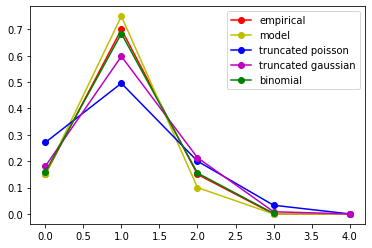

In [66]:
rate = 100
cell = 3
t = 4
p = single_trial_bin[:,((100*single_trial_bin.mean(0)[:,cell]>=rate-1)*(100*single_trial_bin.mean(0)[:,cell]<=rate+1)),cell].flatten()
plt.plot(range(5), [(p == n).sum()/p.shape[0] for n in range(5)], 'r-o', label='empirical')
q = single_trial_bin[:,((100*pred_single_trial3.mean(0)[:,cell]>=rate-1)*(100*pred_single_trial3.mean(0)[:,cell]<=rate+1)),cell].flatten()
plt.plot(range(5), [(q == n).sum()/q.shape[0] for n in range(5)], 'y-o', label='model')
k = 1.99
r_list = np.linspace(0, 2*t, 100)
mean_list = [mean_truncated_poisson(r, k, t) for r in r_list]  
a,b,c,d = curve_fit(sat_func, r_list, mean_list)[0]
r = inverse_sat(rate/100, a, b, c, d)
plt.plot(range(5), [truncated_poisson(n, r, k, t) for n in range(5)], 'b-o', label='truncated poisson')
s = 0.67
n0_list = np.linspace(-t, 2*t, 100)
mean_list = [mean_truncated_gaussian(n0, s, t) for n0 in n0_list]
a,b,c = curve_fit(sigmoid_para, n0_list, mean_list)[0]
n0 = inverse_sigmoid_para(rate/100, a, b, c) 
plt.plot(range(5), [truncated_gaussian(n, n0, s, t) for n in range(5)], 'm-o', label='truncated gaussian')
k = 2.14
p_list = np.linspace(0, 1, 100)
mean_list = [mean_binomial(p, k, t) for p in p_list]
f = interp1d(mean_list, p_list)
p = max(f(rate/100), 0)
plt.plot(range(5), [binomial_scale(n, p, t-1, k) for n in range(5)], 'g-o', label='binomial')
plt.legend()
plt.show()

In [72]:
def poisson_scale2(n, r, k):
    p = np.exp(-r*k)*(r*k)**(n*k)/factorial(n*k)
    return p

def truncated_poisson2(n, r, k, t):
    summation = 0
    for i in range(t):
        summation += poisson_scale2(i, r, k)
    if n >= t:
        return 0
    else:
        return poisson_scale2(n, r, k)/summation

def mean_truncated_poisson2(r, k, t):
    return np.sum([truncated_poisson2(i, r, k, t)*i for i in range(t)])

def log_likelihood_poisson2(k, single_trial_bin, cell, t):
    
    r_list = np.linspace(0, 2*t, 100)
    mean_list = [mean_truncated_poisson2(r, k, t) for r in r_list]
    f = interp1d(mean_list, r_list)
    
    ll = 0
    for time in range(single_trial_bin.shape[1]):
        rate = single_trial_bin[:,time,cell].mean()
        r = max(f(rate), 0)
        for trial in range(single_trial_bin.shape[0]):
            n = single_trial_bin[trial,time,cell]
            ll += np.log(truncated_poisson2(n, r, k, t))
    return ll

In [88]:
single_trial_bin.max((0,1))

array([2., 2., 2., 3., 1., 3.])

In [94]:
t = 3
cell = 0
for k in np.arange(3.8, 3.85, 0.01):
    print(k, log_likelihood_poisson2(k, single_trial_bin, cell, t))

3.8 -7560.216925679431
3.8099999999999996 -7560.216751147491
3.8199999999999994 -7560.220831700169
3.829999999999999 -7560.229122409615
3.839999999999999 -7560.241578907571
3.8499999999999988 -7560.258157401657


In [99]:
t = 3
cell = 1
a = 1
b = 10
assert np.sign(log_likelihood_poisson2(a, single_trial_bin, cell, t) - log_likelihood_poisson2(a+0.01, single_trial_bin, cell, t)) == -1
assert np.sign(log_likelihood_poisson2(b, single_trial_bin, cell, t) - log_likelihood_poisson2(b+0.01, single_trial_bin, cell, t)) == 1
while b-a > 0.01:
    c = (a+b)/2
    sign = np.sign(log_likelihood_poisson2(c, single_trial_bin, cell, t) - log_likelihood_poisson2(c+0.01, single_trial_bin, cell, t))
    if sign == 1:
        b = c
    else:
        a = c
print(a, b)

5.0341796875 5.04296875


In [104]:
t = 3
cell = 2
a = 1
b = 10
assert np.sign(log_likelihood_poisson2(a, single_trial_bin, cell, t) - log_likelihood_poisson2(a+0.01, single_trial_bin, cell, t)) == -1
assert np.sign(log_likelihood_poisson2(b, single_trial_bin, cell, t) - log_likelihood_poisson2(b+0.01, single_trial_bin, cell, t)) == 1
while b-a > 0.01:
    c = (a+b)/2
    sign = np.sign(log_likelihood_poisson2(c, single_trial_bin, cell, t) - log_likelihood_poisson2(c+0.01, single_trial_bin, cell, t))
    if sign == 1:
        b = c
    else:
        a = c
print(a, b)

3.302734375 3.3115234375


In [152]:
t = 4
cell = 3
a = 1
b = 10
assert np.sign(log_likelihood_poisson2(a, single_trial_bin, cell, t) - log_likelihood_poisson2(a+0.01, single_trial_bin, cell, t)) == -1
assert np.sign(log_likelihood_poisson2(b, single_trial_bin, cell, t) - log_likelihood_poisson2(b+0.01, single_trial_bin, cell, t)) == 1
while b-a > 0.01:
    c = (a+b)/2
    sign = np.sign(log_likelihood_poisson2(c, single_trial_bin, cell, t) - log_likelihood_poisson2(c+0.01, single_trial_bin, cell, t))
    if sign == 1:
        b = c
    else:
        a = c
print(a)

3.1005859375


In [105]:
t = 2
cell = 4
a = 1
b = 10
assert np.sign(log_likelihood_poisson2(a, single_trial_bin, cell, t) - log_likelihood_poisson2(a+0.01, single_trial_bin, cell, t)) == -1
assert np.sign(log_likelihood_poisson2(b, single_trial_bin, cell, t) - log_likelihood_poisson2(b+0.01, single_trial_bin, cell, t)) == 1
while b-a > 0.01:
    c = (a+b)/2
    sign = np.sign(log_likelihood_poisson2(c, single_trial_bin, cell, t) - log_likelihood_poisson2(c+0.01, single_trial_bin, cell, t))
    if sign == 1:
        b = c
    else:
        a = c
print(a)

6.09765625


In [107]:
t = 4
cell = 5
a = 0.5
b = 10
assert np.sign(log_likelihood_poisson2(a, single_trial_bin, cell, t) - log_likelihood_poisson2(a+0.01, single_trial_bin, cell, t)) == -1
assert np.sign(log_likelihood_poisson2(b, single_trial_bin, cell, t) - log_likelihood_poisson2(b+0.01, single_trial_bin, cell, t)) == 1
while b-a > 0.01:
    c = (a+b)/2
    sign = np.sign(log_likelihood_poisson2(c, single_trial_bin, cell, t) - log_likelihood_poisson2(c+0.01, single_trial_bin, cell, t))
    if sign == 1:
        b = c
    else:
        a = c
print(a)

0.82470703125


In [126]:
k_list = [3.81, 5.03, 3.30, 3.11, 6.10, 0.82]
t_list = [3,3,3,4,2,4]
tll = 0
for cell in range(6):
    ll = log_likelihood_poisson2(k_list[cell], single_trial_bin, cell, t_list[cell])
    print(cell, ll)
    tll += ll
print('total ll', tll)

0 -7560.216751147491
1 -5771.1977266165
2 -1557.4839735514563
3 -2155.094787828432
4 -3187.2626992256014
5 -4927.478349471936
total ll -25158.73428784142


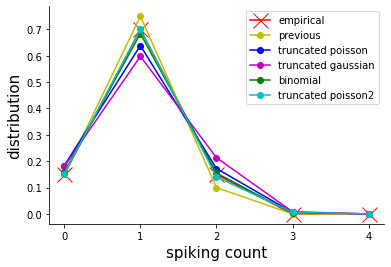

In [484]:
rate = 100
cell = 3
t = 4
p = single_trial_bin[:,((100*single_trial_bin.mean(0)[:,cell]>=rate-1)*(100*single_trial_bin.mean(0)[:,cell]<=rate+1)),cell].flatten()
plt.plot(range(5), [(p == n).sum()/p.shape[0] for n in range(5)], 'r-x', label='empirical', markersize=15)
q = single_trial_bin[:,((100*pred_single_trial3.mean(0)[:,cell]>=rate-1)*(100*pred_single_trial3.mean(0)[:,cell]<=rate+1)),cell].flatten()
plt.plot(range(5), [(q == n).sum()/q.shape[0] for n in range(5)], 'y-o', label='previous')
k = 4.75
r_list = np.linspace(0, 2*t, 100)
mean_list = [mean_truncated_poisson(r, k, t) for r in r_list]  
f = interp1d(mean_list, r_list)
r = max(f(rate/100), 0)
plt.plot(range(5), [truncated_poisson(n, r, k, t) for n in range(5)], 'b-o', label='truncated poisson')
s = 0.67
n0_list = np.linspace(-t, 2*t, 100)
mean_list = [mean_truncated_gaussian(n0, s, t) for n0 in n0_list]
a,b,c = curve_fit(sigmoid_para, n0_list, mean_list)[0]
n0 = inverse_sigmoid_para(rate/100, a, b, c) 
plt.plot(range(5), [truncated_gaussian(n, n0, s, t) for n in range(5)], 'm-o', label='truncated gaussian')
k = 2.14
p_list = np.linspace(0, 1, 100)
mean_list = [mean_binomial(p, k, t) for p in p_list]
f = interp1d(mean_list, p_list)
p = max(f(rate/100), 0)
plt.plot(range(5), [binomial_scale(n, p, t-1, k) for n in range(5)], 'g-o', label='binomial')
k = 3.11
r_list = np.linspace(0, 2*t, 100)
mean_list = [mean_truncated_poisson2(r, k, t) for r in r_list]  
f = interp1d(mean_list, r_list)
r = max(f(rate/100), 0)
plt.plot(range(5), [truncated_poisson2(n, r, k, t) for n in range(5)], 'c-o', label='truncated poisson2')
plt.xticks(range(5))
plt.xlabel('spiking count', fontsize=15)
plt.ylabel('distribution', fontsize=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend()
plt.show()

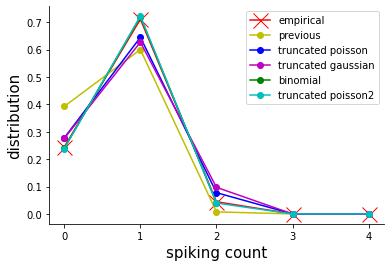

In [485]:
rate = 80
cell = 0
t = 3
p = single_trial_bin[:,((100*single_trial_bin.mean(0)[:,cell]>=rate-1)*(100*single_trial_bin.mean(0)[:,cell]<=rate+1)),cell].flatten()
plt.plot(range(5), [(p == n).sum()/p.shape[0] for n in range(5)], 'r-x', label='empirical', markersize=15)
q = single_trial_bin[:,((100*pred_single_trial3.mean(0)[:,cell]>=rate-1)*(100*pred_single_trial3.mean(0)[:,cell]<=rate+1)),cell].flatten()
plt.plot(range(5), [(q == n).sum()/q.shape[0] for n in range(5)], 'y-o', label='previous')
k = 5.56
r_list = np.linspace(0, 2*t, 100)
mean_list = [mean_truncated_poisson(r, k, t) for r in r_list]  
f = interp1d(mean_list, r_list)
r = max(f(rate/100), 0)
plt.plot(range(5), [truncated_poisson(n, r, k, t) for n in range(5)], 'b-o', label='truncated poisson')
s = 0.61
n0_list = np.linspace(-t, 2*t, 100)
mean_list = [mean_truncated_gaussian(n0, s, t) for n0 in n0_list]
a,b,c = curve_fit(sigmoid_para, n0_list, mean_list)[0]
n0 = inverse_sigmoid_para(rate/100, a, b, c) 
plt.plot(range(5), [truncated_gaussian(n, n0, s, t) for n in range(5)], 'm-o', label='truncated gaussian')
k = 2.17
p_list = np.linspace(0, 1, 100)
mean_list = [mean_binomial(p, k, t) for p in p_list]
f = interp1d(mean_list, p_list)
p = max(f(rate/100), 0)
plt.plot(range(5), [binomial_scale(n, p, t-1, k) for n in range(5)], 'g-o', label='binomial')
k = 3.81
r_list = np.linspace(0, 2*t, 100)
mean_list = [mean_truncated_poisson2(r, k, t) for r in r_list]  
f = interp1d(mean_list, r_list)
r = max(f(rate/100), 0)
plt.plot(range(5), [truncated_poisson2(n, r, k, t) for n in range(5)], 'c-o', label='truncated poisson2')
plt.xticks(range(5))
plt.xlabel('spiking count', fontsize=15)
plt.ylabel('distribution', fontsize=15)
plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

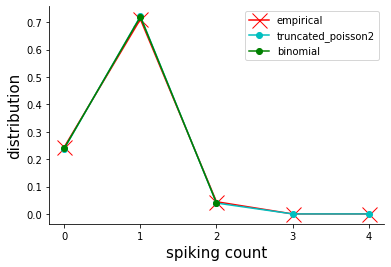

In [532]:
from fnn.notebook.distributions import recording_stats

rate = 80
cell = 0
t = 3
dis = distribution(t)

file_path = '/home/xhding/tem_stim/21-03-15/naturalscene.h5'
cells = [0,1,2,3,4,6]
recording = recording_stats(file_path, cells)
mean_rate = recording.single_trial_bin.mean(0) * 100
em_dis = recording.stats_rate(mean_rate, cell, rate)[2]
plt.plot(range(len(em_dis)), em_dis, 'r-x', label='empirical', markersize=15)

k = 3.81
r = dis.rate2para('truncated_poisson', k, rate, p_version=2)
plt.plot(range(t+2),[dis.truncated_poisson(i, r, k, 2) for i in range(t+2)], 'c-o', label='truncated_poisson2')

k=2.17
r = dis.rate2para('binomial_scale', k, rate)
plt.plot(range(t+2),[dis.binomial_scale(i, r, k) for i in range(t+2)], 'g-o', label='binomial')

plt.xticks(range(5))
plt.xlabel('spiking count', fontsize=15)
plt.ylabel('distribution', fontsize=15)
plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

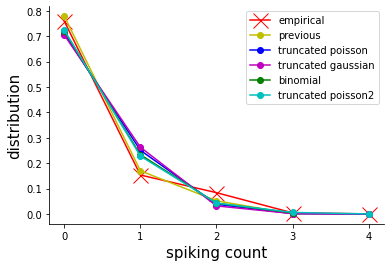

In [486]:
rate = 33
cell = 5
t = 4
p = single_trial_bin[:,((100*single_trial_bin.mean(0)[:,cell]>=rate-1)*(100*single_trial_bin.mean(0)[:,cell]<=rate+1)),cell].flatten()
plt.plot(range(5), [(p == n).sum()/p.shape[0] for n in range(5)], 'r-x', label='empirical', markersize=15)
q = single_trial_bin[:,((100*pred_single_trial3.mean(0)[:,cell]>=rate-1)*(100*pred_single_trial3.mean(0)[:,cell]<=rate+1)),cell].flatten()
plt.plot(range(5), [(q == n).sum()/q.shape[0] for n in range(5)], 'y-o', label='previous')
k = 1.49
r_list = np.linspace(0, 2*t, 100)
mean_list = [mean_truncated_poisson(r, k, t) for r in r_list]  
f = interp1d(mean_list, r_list)
r = max(f(rate/100), 0)
plt.plot(range(5), [truncated_poisson(n, r, k, t) for n in range(5)], 'b-o', label='truncated poisson')
s = 0.94
n0_list = np.linspace(-t, 2*t, 100)
mean_list = [mean_truncated_gaussian(n0, s, t) for n0 in n0_list]
a,b,c = curve_fit(sigmoid_para, n0_list, mean_list)[0]
n0 = inverse_sigmoid_para(rate/100, a, b, c) 
plt.plot(range(5), [truncated_gaussian(n, n0, s, t) for n in range(5)], 'm-o', label='truncated gaussian')
k = 0.64
p_list = np.linspace(0, 1, 100)
mean_list = [mean_binomial(p, k, t) for p in p_list]
f = interp1d(mean_list, p_list)
p = max(f(rate/100), 0)
plt.plot(range(5), [binomial_scale(n, p, t-1, k) for n in range(5)], 'g-o', label='binomial')
k = 0.82
r_list = np.linspace(0, 2*t, 100)
mean_list = [mean_truncated_poisson2(r, k, t) for r in r_list]  
f = interp1d(mean_list, r_list)
r = max(f(rate/100), 0)
plt.plot(range(5), [truncated_poisson2(n, r, k, t) for n in range(5)], 'c-o', label='truncated poisson2')
plt.xticks(range(5))
plt.xlabel('spiking count', fontsize=15)
plt.ylabel('distribution', fontsize=15)
plt.legend()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

In [189]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_0.10_pearson_0.3942.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

BN_CNN_Stack(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.05, trainable=False, adapt=False, momentum=0.95)
    (4): ReLU()
  )
  (amacrine): Sequential(
    (0): Reshape(shape=(-1, 8, 36, 36))
    (1): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Seq

In [190]:
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)
test_pc

0.7372721736435023

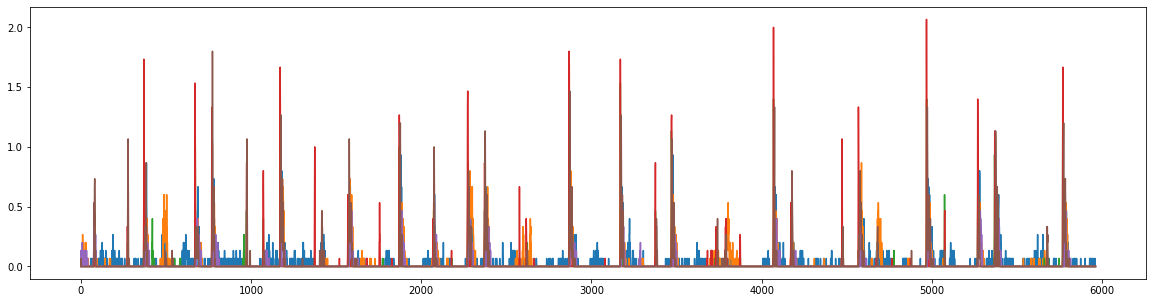

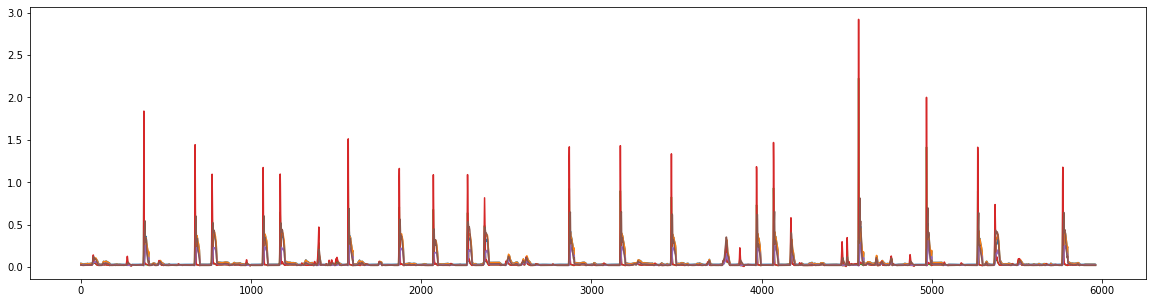

In [170]:
plt.figure(figsize=(20,5))
plt.plot(targ)
plt.show()
plt.figure(figsize=(20,5))
plt.plot(pred)
plt.show()

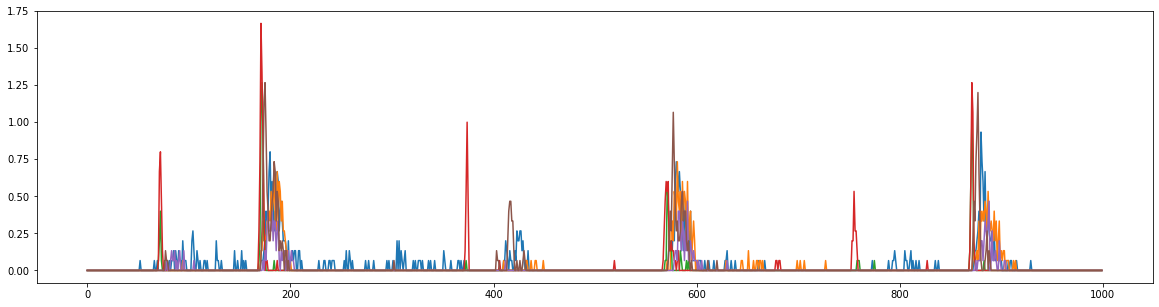

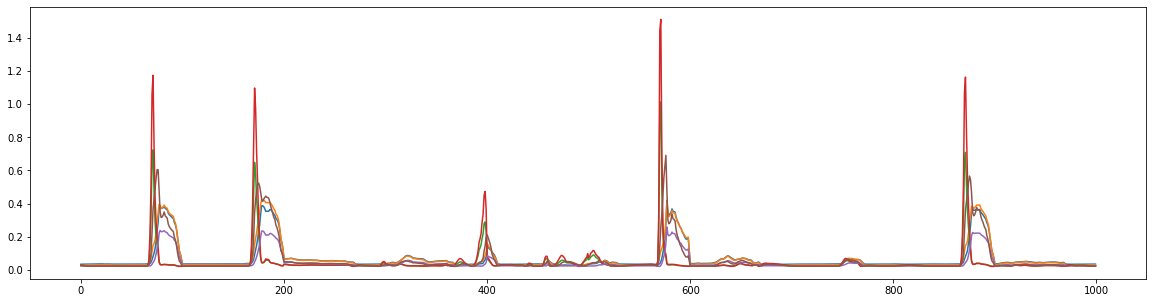

In [172]:
plt.figure(figsize=(20,5))
plt.plot(targ[1000:2000])
plt.show()
plt.figure(figsize=(20,5))
plt.plot(pred[1000:2000])
plt.show()

In [173]:
single_trial_bin.shape

(15, 5963, 6)

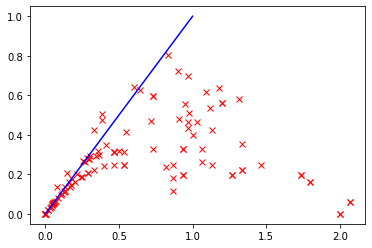

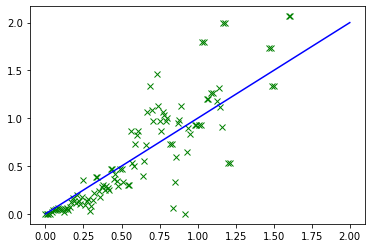

In [196]:
means = []
variances = []
rates = []
for rate in range(200):
    mean, var, _ = emperical(single_trial_bin, 80*pred, cell=3, rate=rate)
    means.append(mean)
    variances.append(var)
    rates.append(rate/100)
plt.plot(means, variances, 'rx')
plt.plot([0, 1], [0, 1], 'b')
plt.show()
plt.plot(rates, means, 'gx')
plt.plot([0, 2], [0, 2], 'b')
plt.show()

In [197]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_0.17_pearson_0.2946.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

BN_CNN_Stack(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.05, trainable=False, adapt=False, momentum=0.95)
    (4): ReLU()
  )
  (amacrine): Sequential(
    (0): Reshape(shape=(-1, 8, 36, 36))
    (1): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Seq

In [198]:
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)
test_pc

0.5481728487170621

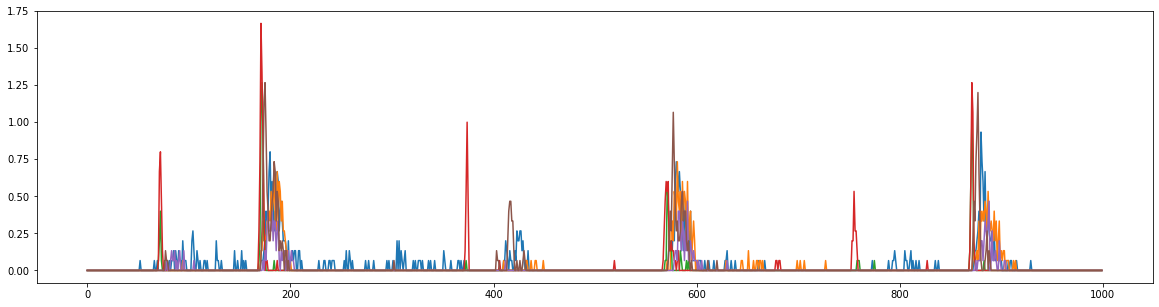

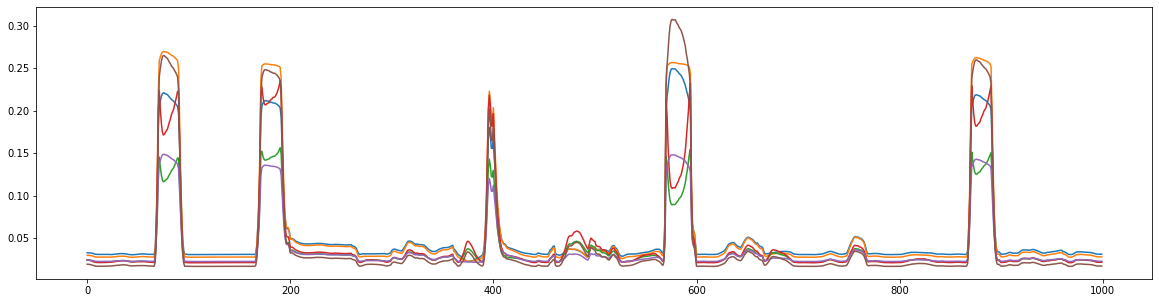

In [199]:
plt.figure(figsize=(20,5))
plt.plot(targ[1000:2000])
plt.show()
plt.figure(figsize=(20,5))
plt.plot(pred[1000:2000])
plt.show()

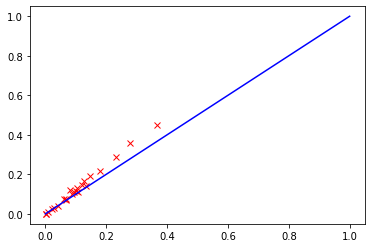

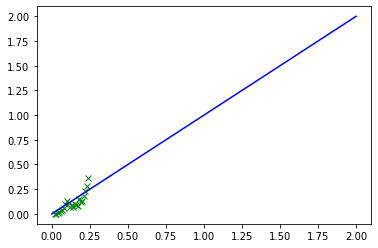

In [201]:
means = []
variances = []
rates = []
for rate in range(200):
    mean, var, _ = emperical(single_trial_bin, 100*pred, cell=3, rate=rate)
    means.append(mean)
    variances.append(var)
    rates.append(rate/100)
plt.plot(means, variances, 'rx')
plt.plot([0, 1], [0, 1], 'b')
plt.show()
plt.plot(rates, means, 'gx')
plt.plot([0, 2], [0, 2], 'b')
plt.show()

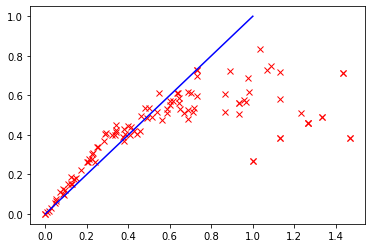

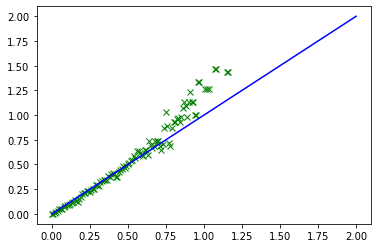

In [238]:
sigma = 0.0122
with h5py.File('/home/xhding/tem_stim/21-03-15/naturalscene.h5', 'r') as f:
    single_trial_bin = np.array(f['test']['repeats/binned'])
test_response = []
time_upsample = np.linspace(0, 60.02, 6003)
for trial in range(single_trial_bin.shape[0]):
    response = []
    for cell in range(single_trial_bin.shape[1]):
        rate = pyret.spiketools.estfr(single_trial_bin[trial, cell], time_upsample, sigma=sigma)
        response.append(rate)
    test_response.append(np.stack(response))
single_trial = np.stack(test_response)
single_trial_bin = np.swapaxes(single_trial_bin,1,2)[:,40:6003,[0,1,2,3,4,6]]
single_trial = np.swapaxes(single_trial,1,2)[:,40:6003,[0,1,2,3,4,6]]

means = []
variances = []
rates = []
for rate in range(200):
    mean, var, _ = emperical(single_trial_bin, single_trial.mean(0), cell=5, rate=rate)
    means.append(mean)
    variances.append(var)
    rates.append(rate/100)
plt.plot(means, variances, 'rx')
plt.plot([0, 1], [0, 1], 'b')
plt.show()
plt.plot(rates, means, 'gx')
plt.plot([0, 2], [0, 2], 'b')
plt.show()

In [246]:
type(0.01)==float

True

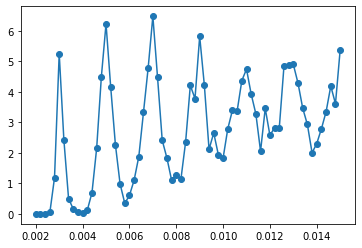

0.002 [0.00246774]
0.004 [0.04419416]
0.0058 [0.3503916]
0.0078 [1.10875064]
0.008199999999999999 [1.1479598]
0.008799999999999999 [3.78155603]
0.009399999999999999 [2.11864104]
0.01 [1.8324166]
0.0106 [3.3743161]
0.0116 [2.05707241]
0.011999999999999999 [2.57611541]
0.0124 [2.82210379]
0.0138 [2.00578726]
0.014799999999999999 [3.61110847]


In [527]:
file_path = '/home/xhding/tem_stim/21-03-15/naturalscene.h5'
cells = [0,1,2,3,4,6]
recording = recording_stats(file_path, cells)
sigmas = np.linspace(0.002, 0.015, 66)
residuals = []
for sigma in sigmas:
    residual = recording.smooth_residual(sigma, cell=3)
    residuals.append(residual)
plt.plot(sigmas, residuals, '-o')
plt.show()
for i in range(len(sigmas)-1):
    if residuals[i] < residuals[i+1] and residuals[i] < residuals[i-1]:
        print(sigmas[i], residuals[i])

In [533]:
print(dis.KL('binomial_scale', 2.17, recording, 0))
print(dis.KL("truncated_poisson", 3.81, recording, 0, p_version=2))
print(dis.KL("truncated_poisson", 5.56, recording, 0, p_version=1))

0.0019865191376584957
0.001948219399649791
0.009476985386041845


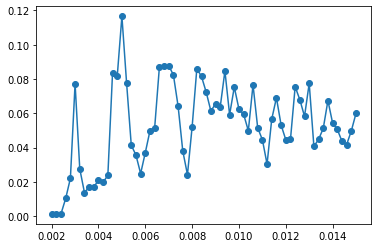

0.0034 [0.01381762]
0.0042 [0.01986281]
0.0048 [0.08145876]
0.0058 [0.02485209]
0.0078 [0.02422388]
0.008799999999999999 [0.06133419]
0.0092 [0.06371353]
0.0096 [0.05914612]
0.0104 [0.04981607]
0.0112 [0.03037288]
0.011999999999999999 [0.04454542]
0.012799999999999999 [0.05816705]
0.013199999999999998 [0.04071519]
0.014599999999999998 [0.04177867]


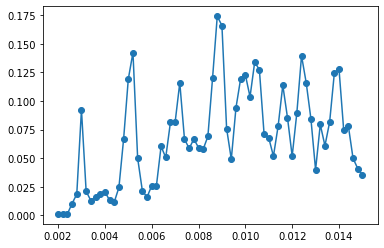

0.0034 [0.0129243]
0.004399999999999999 [0.01154016]
0.0058 [0.01588712]
0.0062 [0.02552557]
0.0066 [0.05062245]
0.007599999999999999 [0.05850519]
0.008199999999999999 [0.05789782]
0.009399999999999999 [0.04911213]
0.010199999999999999 [0.10367479]
0.0112 [0.05178794]
0.011999999999999999 [0.05178561]
0.013 [0.03982674]
0.013399999999999999 [0.0609306]
0.014199999999999999 [0.07486759]


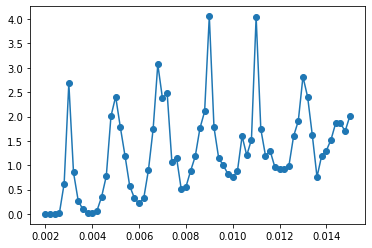

0.002 [0.00194844]
0.004 [0.02420448]
0.006 [0.21592928]
0.006999999999999999 [2.36989776]
0.0073999999999999995 [1.07643001]
0.0078 [0.51261303]
0.01 [0.75852008]
0.0106 [1.20430706]
0.011399999999999999 [1.19520113]
0.012199999999999999 [0.91525996]
0.0136 [0.76063517]
0.014799999999999999 [1.69615154]


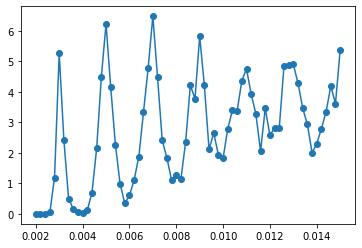

0.002 [0.00246774]
0.004 [0.04419416]
0.0058 [0.3503916]
0.0078 [1.10875064]
0.008199999999999999 [1.1479598]
0.008799999999999999 [3.78155603]
0.009399999999999999 [2.11864104]
0.01 [1.8324166]
0.0106 [3.3743161]
0.0116 [2.05707241]
0.011999999999999999 [2.57611541]
0.0124 [2.82210379]
0.0138 [2.00578791]
0.014799999999999999 [3.61110961]


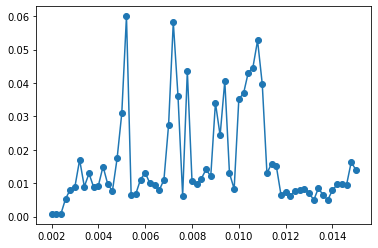

0.0034 [0.00895183]
0.0038 [0.0087587]
0.0046 [0.00765425]
0.0054 [0.00648747]
0.0066 [0.00790275]
0.007599999999999999 [0.00623946]
0.008199999999999999 [0.00970818]
0.008799999999999999 [0.01203386]
0.0092 [0.02428701]
0.0098 [0.00826112]
0.0112 [0.01296229]
0.0118 [0.00650244]
0.012199999999999999 [0.00625808]
0.013199999999999998 [0.00490424]
0.0138 [0.00502409]
0.014599999999999998 [0.00947111]


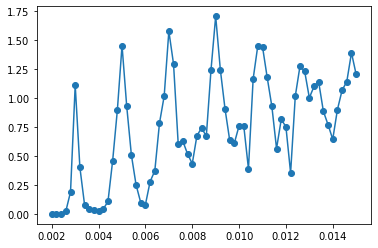

0.004 [0.02922981]
0.006 [0.08300684]
0.0073999999999999995 [0.60272047]
0.008 [0.43522427]
0.0086 [0.67043331]
0.0098 [0.61294155]
0.0104 [0.3901197]
0.0116 [0.56411052]
0.012199999999999999 [0.3552225]
0.013 [1.00172114]
0.013999999999999999 [0.6443116]


In [362]:
for c in range(6):
    sigmas = np.linspace(0.002, 0.015, 66)
    residuals = []
    for sigma in sigmas:
        with h5py.File('/home/xhding/tem_stim/21-03-15/naturalscene.h5', 'r') as f:
            single_trial_bin = np.array(f['test']['repeats/binned'])
        test_response = []
        time_upsample = np.linspace(0, 60.02, 6003)
        for trial in range(single_trial_bin.shape[0]):
            response = []
            for cell in range(single_trial_bin.shape[1]):
                rate = estfr(single_trial_bin[trial, cell], time_upsample, sigma=sigma)
                response.append(rate)
            test_response.append(np.stack(response))
        single_trial = np.stack(test_response)
        single_trial_bin = np.swapaxes(single_trial_bin,1,2)[:,40:6003,[0,1,2,3,4,6]]
        single_trial = np.swapaxes(single_trial,1,2)[:,40:6003,[0,1,2,3,4,6]]
        means = []
        rates = []
        for rate in range(300):
            mean, _, _ = emperical(single_trial_bin, single_trial.mean(0), cell=c, rate=rate)
            means.append(mean)
            rates.append(rate/100)
        residual = np.polyfit(np.array(rates)[~np.isnan(means)], np.array(means)[~np.isnan(means)], 3, full=True)[1]
        residuals.append(residual)

    plt.plot(sigmas, residuals, '-o')
    plt.show()
    for i in range(len(sigmas)-1):
        if residuals[i] < residuals[i+1] and residuals[i] < residuals[i-1]:
            print(sigmas[i], residuals[i])

In [248]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_-3.34_pearson_0.6618.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

BN_CNN_Stack(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.05, trainable=False, adapt=False, momentum=0.95)
    (4): ReLU()
  )
  (amacrine): Sequential(
    (0): Reshape(shape=(-1, 8, 36, 36))
    (1): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Seq

In [249]:
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)
test_pc

0.8433408689024412

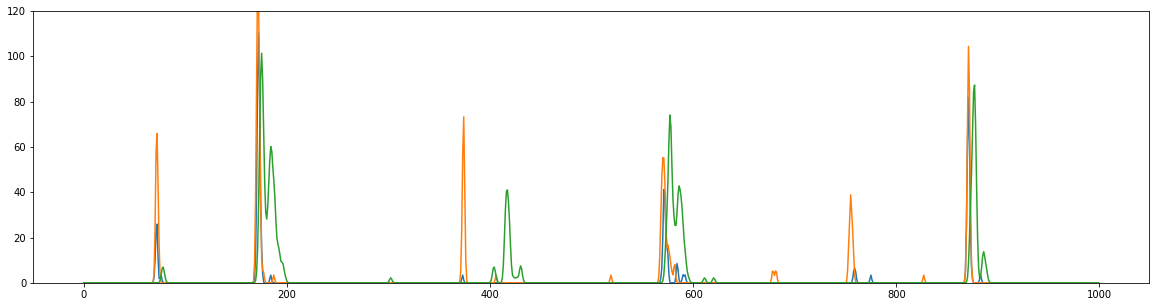

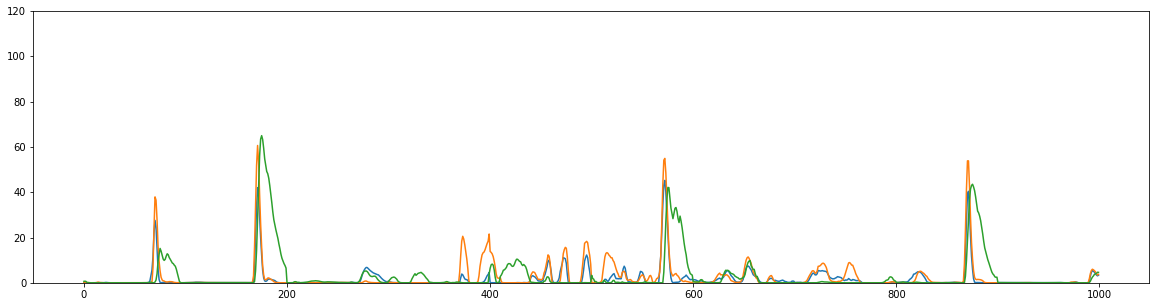

In [276]:
plt.figure(figsize=(20,5))
plt.plot(targ[1000:2000, [2,3,5]])
plt.ylim(0,120)
plt.show()
plt.figure(figsize=(20,5))
plt.plot(pred[1000:2000, [2,3,5]])
plt.ylim(0,120)
plt.show()

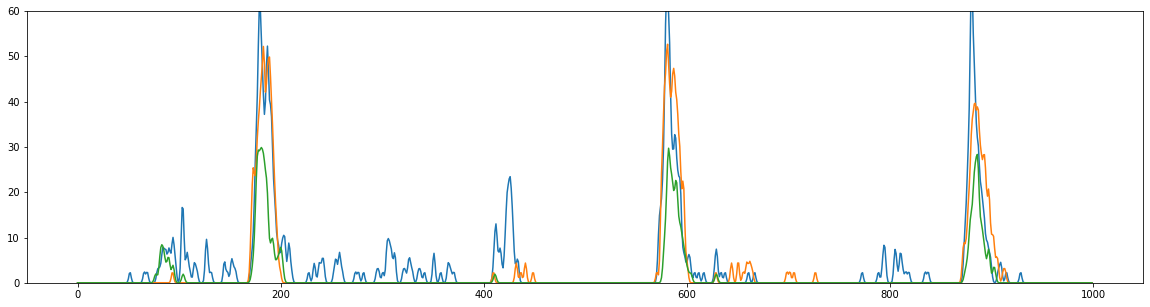

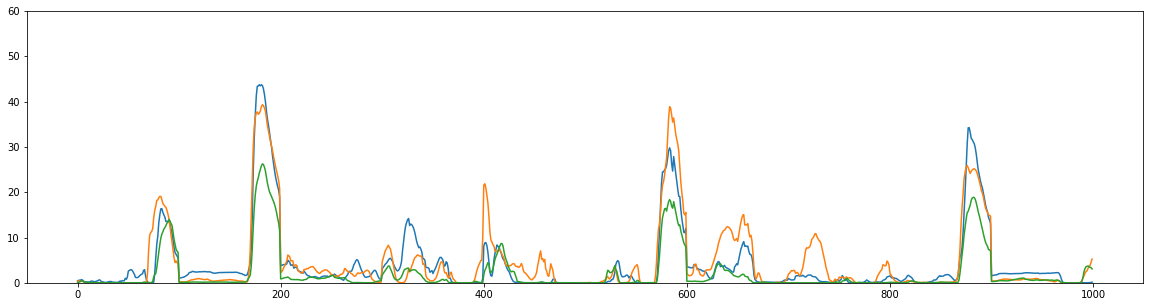

In [272]:
plt.figure(figsize=(20,5))
plt.ylim(0,60)
plt.plot(targ[1000:2000, [0,1,4]])
plt.show()
plt.figure(figsize=(20,5))
plt.ylim(0,60)
plt.plot(pred[1000:2000, [0,1,4]])
plt.show()

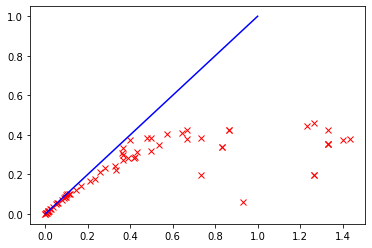

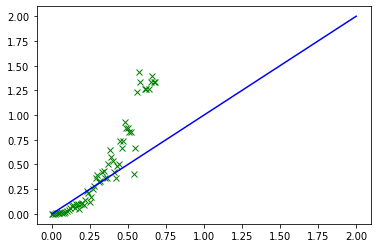

In [288]:
means = []
variances = []
rates = []
for rate in range(200):
    mean, var, _ = emperical(single_trial_bin, pred, cell=2, rate=rate)
    means.append(mean)
    variances.append(var)
    rates.append(rate/100)
plt.plot(means, variances, 'rx')
plt.plot([0, 1], [0, 1], 'b')
plt.show()
plt.plot(rates, means, 'gx')
plt.plot([0, 2], [0, 2], 'b')
plt.show()

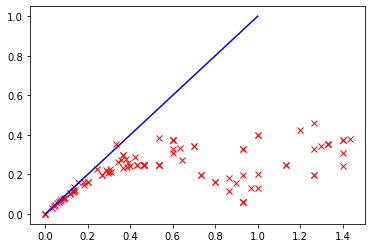

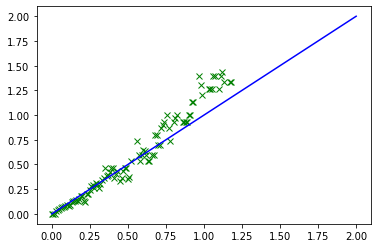

In [285]:
means = []
variances = []
rates = []
for rate in range(200):
    mean, var, _ = emperical(single_trial_bin, targ, cell=2, rate=rate)
    means.append(mean)
    variances.append(var)
    rates.append(rate/100)
plt.plot(means, variances, 'rx')
plt.plot([0, 1], [0, 1], 'b')
plt.show()
plt.plot(rates, means, 'gx')
plt.plot([0, 2], [0, 2], 'b')
plt.show()

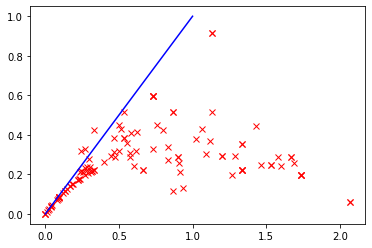

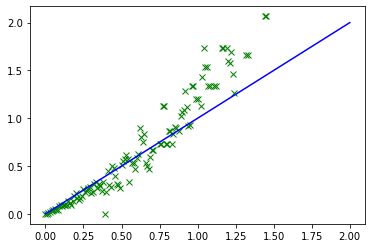

array([1.82532728])

In [377]:
sigma = 0.010001
with h5py.File('/home/xhding/tem_stim/21-03-15/naturalscene.h5', 'r') as f:
    single_trial_bin = np.array(f['test']['repeats/binned'])
test_response = []
time_upsample = np.linspace(0, 60.02, 6003)
for trial in range(single_trial_bin.shape[0]):
    response = []
    for cell in range(single_trial_bin.shape[1]):
        rate = estfr(single_trial_bin[trial, cell], time_upsample, sigma=sigma)
        response.append(rate)
    test_response.append(np.stack(response))
single_trial = np.stack(test_response)
single_trial_bin = np.swapaxes(single_trial_bin,1,2)[:,40:6003,[0,1,2,3,4,6]]
single_trial = np.swapaxes(single_trial,1,2)[:,40:6003,[0,1,2,3,4,6]]

means = []
variances = []
rates = []
for rate in range(300):
    mean, var, _ = emperical(single_trial_bin, single_trial.mean(0), cell=3, rate=rate)
    means.append(mean)
    variances.append(var)
    rates.append(rate/100)
plt.plot(means, variances, 'rx')
plt.plot([0, 1], [0, 1], 'b')
plt.show()
plt.plot(rates, means, 'gx')
plt.plot([0, 2], [0, 2], 'b')
plt.show()
np.polyfit(np.array(rates)[~np.isnan(means)], np.array(means)[~np.isnan(means)], 3, full=True)[1]

0.8416008353795542


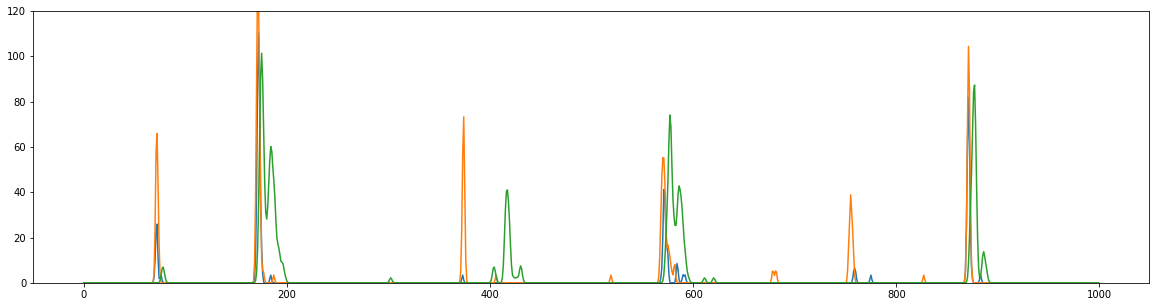

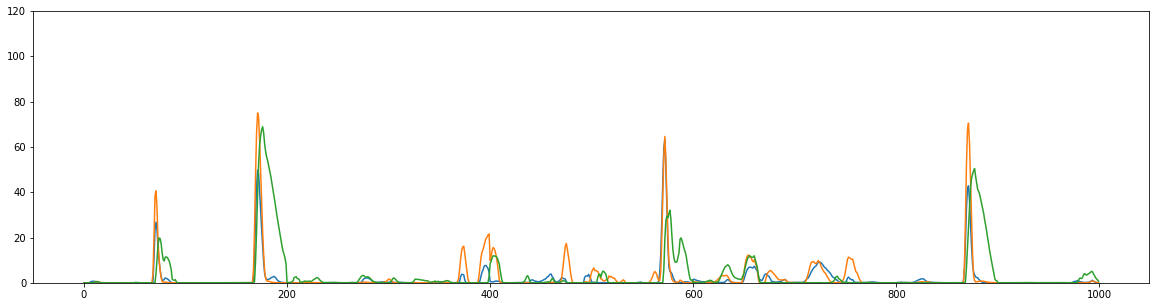

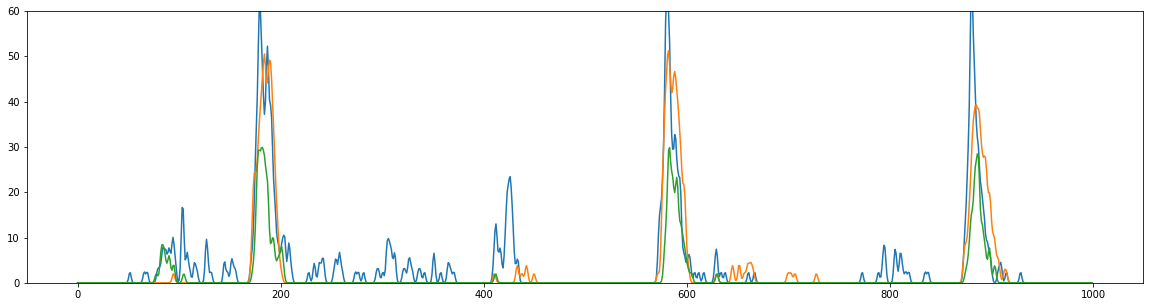

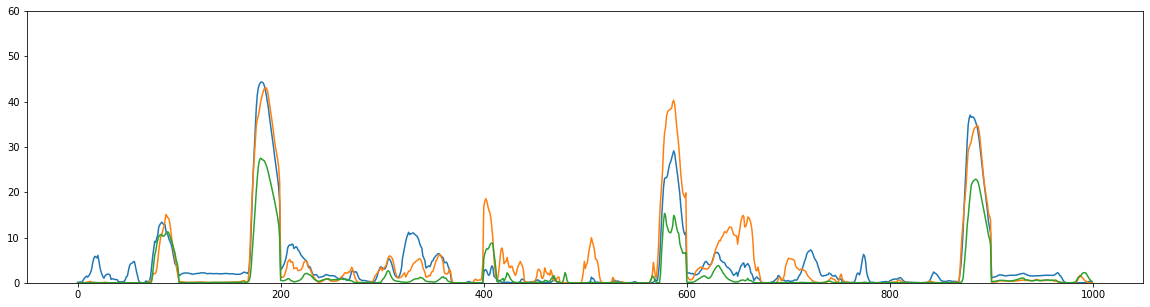

In [471]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_-3.37_pearson_0.6658.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)
print(test_pc)
plt.figure(figsize=(20,5))
plt.plot(targ[1000:2000, [2,3,5]])
plt.ylim(0,120)
plt.show()
plt.figure(figsize=(20,5))
plt.plot(pred[1000:2000, [2,3,5]])
plt.ylim(0,120)
plt.show()
plt.figure(figsize=(20,5))
plt.ylim(0,60)
plt.plot(targ[1000:2000, [0,1,4]])
plt.show()
plt.figure(figsize=(20,5))
plt.ylim(0,60)
plt.plot(pred[1000:2000, [0,1,4]])
plt.show()

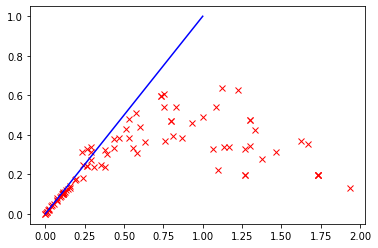

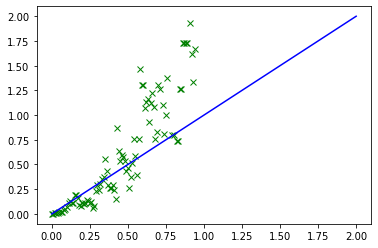

In [476]:
means = []
variances = []
rates = []
for rate in range(200):
    mean, var, _ = emperical(single_trial_bin, pred, cell=3, rate=rate)
    means.append(mean)
    variances.append(var)
    rates.append(rate/100)
plt.plot(means, variances, 'rx')
plt.plot([0, 1], [0, 1], 'b')
plt.show()
plt.plot(rates, means, 'gx')
plt.plot([0, 2], [0, 2], 'b')
plt.show()

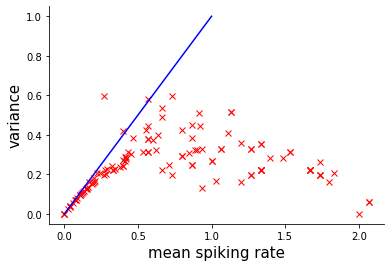

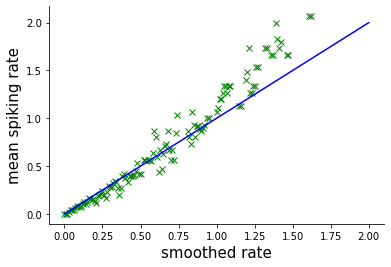

In [488]:
means = []
variances = []
rates = []
for rate in range(200):
    mean, var, _ = emperical(single_trial_bin, targ, cell=3, rate=rate)
    means.append(mean)
    variances.append(var)
    rates.append(rate/100)
plt.plot(means, variances, 'rx')
plt.plot([0, 1], [0, 1], 'b')
plt.ylabel('variance', fontsize=15)
plt.xlabel('mean spiking rate', fontsize=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()
plt.plot(rates, means, 'gx')
plt.plot([0, 2], [0, 2], 'b')
plt.xlabel('smoothed rate', fontsize=15)
plt.ylabel('mean spiking rate', fontsize=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

0.7381819937937383


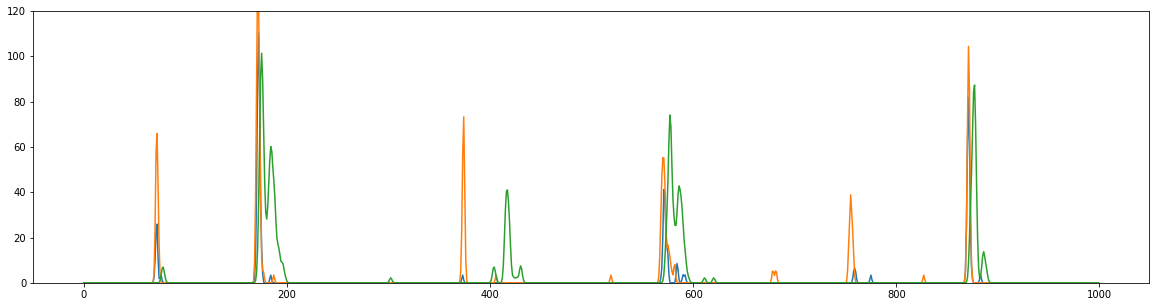

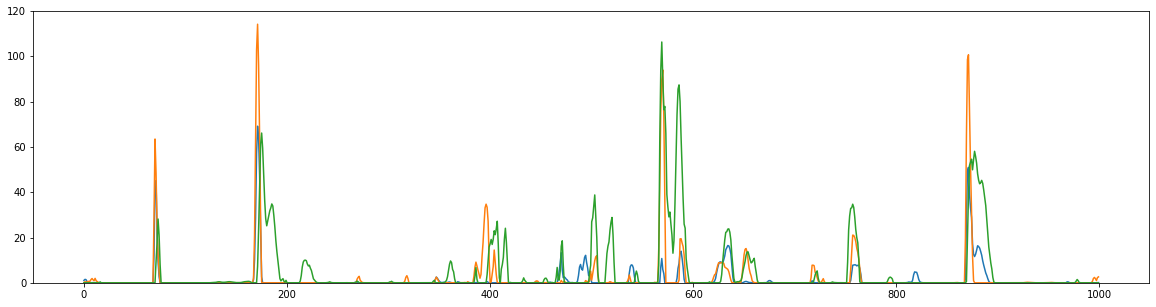

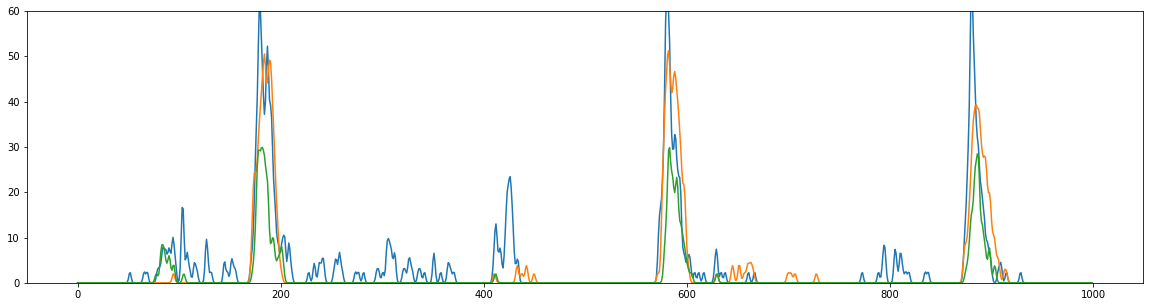

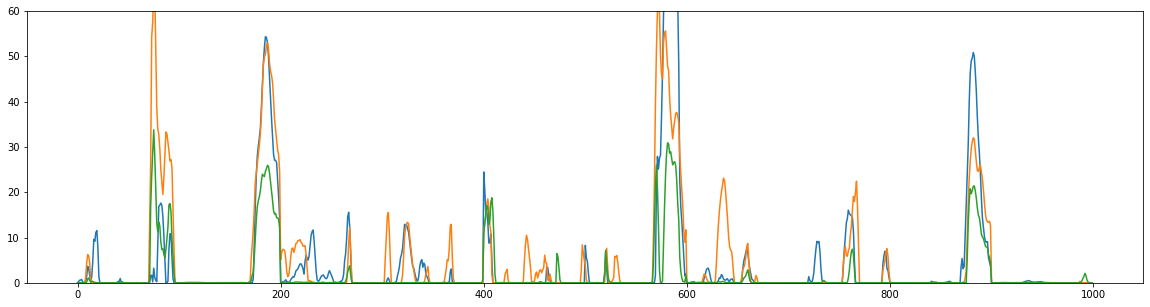

In [491]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_55.85_pearson_0.7565.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)
print(test_pc)
plt.figure(figsize=(20,5))
plt.plot(targ[1000:2000, [2,3,5]])
plt.ylim(0,120)
plt.show()
plt.figure(figsize=(20,5))
plt.plot(pred[1000:2000, [2,3,5]])
plt.ylim(0,120)
plt.show()
plt.figure(figsize=(20,5))
plt.ylim(0,60)
plt.plot(targ[1000:2000, [0,1,4]])
plt.show()
plt.figure(figsize=(20,5))
plt.ylim(0,60)
plt.plot(pred[1000:2000, [0,1,4]])
plt.show()

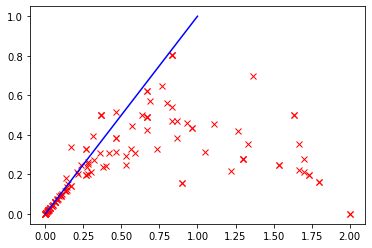

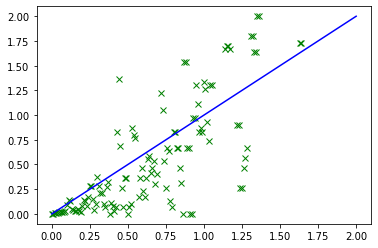

In [492]:
means = []
variances = []
rates = []
for rate in range(200):
    mean, var, _ = emperical(single_trial_bin, pred, cell=3, rate=rate)
    means.append(mean)
    variances.append(var)
    rates.append(rate/100)
plt.plot(means, variances, 'rx')
plt.plot([0, 1], [0, 1], 'b')
plt.show()
plt.plot(rates, means, 'gx')
plt.plot([0, 2], [0, 2], 'b')
plt.show()

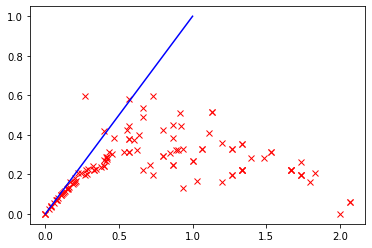

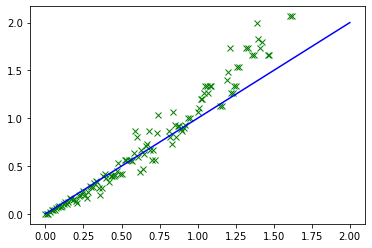

In [478]:
means = []
variances = []
rates = []
for rate in range(200):
    mean, var, _ = emperical(single_trial_bin, targ, cell=3, rate=rate)
    means.append(mean)
    variances.append(var)
    rates.append(rate/100)
plt.plot(means, variances, 'rx')
plt.plot([0, 1], [0, 1], 'b')
plt.show()
plt.plot(rates, means, 'gx')
plt.plot([0, 2], [0, 2], 'b')
plt.show()